# Machine Learning 1 - Supporting File

Analysis of cancellations in INN Hotels Group

Author: Krishnan Chathadi

## Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Split data
from sklearn.model_selection import train_test_split

# Regression analysis
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score 
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_recall_curve, roc_curve

# Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

## Functions

In [3]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined
    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="brown", linestyle="-"
    )  # Add median to the histogram
    plt.show()

In [4]:
def labeled_barplot(data, feature, perc=False, n=None, custom_order=[]):
    """
    Barplot with percentage at the top
    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    custom_order: list of categories in the order you want
    """
    total = len(data[feature])  # length of the column
    count = data[feature].nunique()

    if len(custom_order) == 0:
        custom_order = data[feature].value_counts().index[:n]
    else:
        custom_order = custom_order

    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))
    plt.xticks(rotation=90, fontsize=15)

    # Adjust bar width if there are too many 
    barWidth = 0.8
    if count > 10:
        barWidth = 0.6
        
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=custom_order
    )
    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category
        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot
        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.tight_layout()
    plt.show()  # show the plot

In [5]:
def print_performance_metrics(data, pred):
    accuracy = np.round(accuracy_score(data, pred),2 )
    recall = np.round(recall_score(data, pred),2 )
    precision = np.round(precision_score(data, pred),2 )
    f1 = np.round(f1_score(data, pred),2)
    out_dict = {'Accuracy' : accuracy,
            'Recall' : recall,
            'Precision' : precision,
            'F1 score' : f1}
    
    print('Accuracy score = ', accuracy)
    print('Recall score = ', recall)
    print('Precision score = ', precision)
    print('F1 score = ', f1)
    return out_dict
    

In [6]:
def create_confusion_matrix(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="g")
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()

## Exploratory Data Analysis

### Import data and get an overview

In [7]:
# Import the data
df_InnFromCSV = pd.read_csv('INNHotelsGroup.csv')
df_InnFromCSV

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [8]:
# Check the data
df_InnFromCSV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

* There are 36275 rows of data with 19 columns.
* There are no missing values.

In [9]:
# Describe the columns
df_InnFromCSV.describe(include='all').round(2).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Booking_ID,36275,36275,INN00001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_adults,36275.0,NaN,NaN,NaN,1.84,0.52,0.0,2.0,2.0,2.0,4.0
no_of_children,36275.0,NaN,NaN,NaN,0.11,0.4,0.0,0.0,0.0,0.0,10.0
no_of_weekend_nights,36275.0,NaN,NaN,NaN,0.81,0.87,0.0,0.0,1.0,2.0,7.0
no_of_week_nights,36275.0,NaN,NaN,NaN,2.2,1.41,0.0,1.0,2.0,3.0,17.0
type_of_meal_plan,36275,4,Meal Plan 1,27835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_car_parking_space,36275.0,NaN,NaN,NaN,0.03,0.17,0.0,0.0,0.0,0.0,1.0
room_type_reserved,36275,7,Room_Type 1,28130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_time,36275.0,NaN,NaN,NaN,85.23,85.93,0.0,17.0,57.0,126.0,443.0
arrival_year,36275.0,NaN,NaN,NaN,2017.82,0.38,2017.0,2018.0,2018.0,2018.0,2018.0


### Univariate Analysis

In [10]:
# Create a copy of the dataframe. This new dataframe will be modified to make it optimal for analysis
df_Inn = df_InnFromCSV.copy()

In [11]:
# Drop Booking_ID
df_Inn.drop('Booking_ID', axis=1, inplace=True)
df_Inn

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [12]:
# Check distribution of adults
df_Inn['no_of_adults'].value_counts(), df_Inn['no_of_adults'].value_counts(normalize=True)

(no_of_adults
 2    26108
 1     7695
 3     2317
 0      139
 4       16
 Name: count, dtype: int64,
 no_of_adults
 2    0.719724
 1    0.212130
 3    0.063873
 0    0.003832
 4    0.000441
 Name: proportion, dtype: float64)

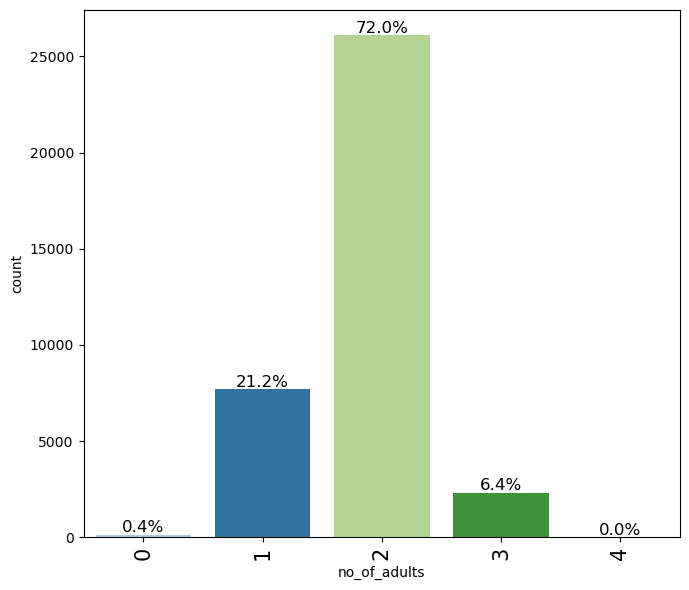

In [13]:
no_adults_order = list(range(0,5))
labeled_barplot(df_Inn, 'no_of_adults', custom_order=no_adults_order, perc=True)

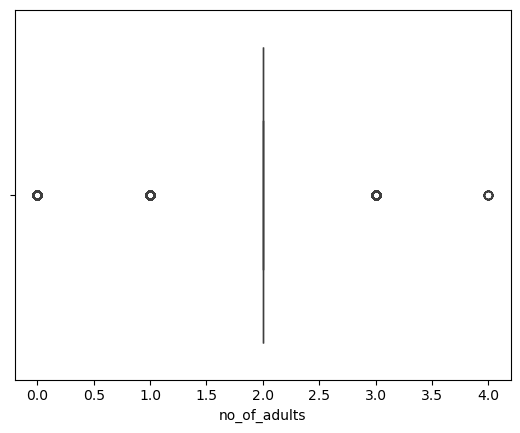

In [14]:
sns.boxplot(df_Inn, x = 'no_of_adults')
plt.show()

In [15]:
# Check distribution of children
df_Inn['no_of_children'].value_counts(), df_Inn['no_of_children'].value_counts(normalize=True)

(no_of_children
 0     33577
 1      1618
 2      1058
 3        19
 9         2
 10        1
 Name: count, dtype: int64,
 no_of_children
 0     0.925624
 1     0.044604
 2     0.029166
 3     0.000524
 9     0.000055
 10    0.000028
 Name: proportion, dtype: float64)

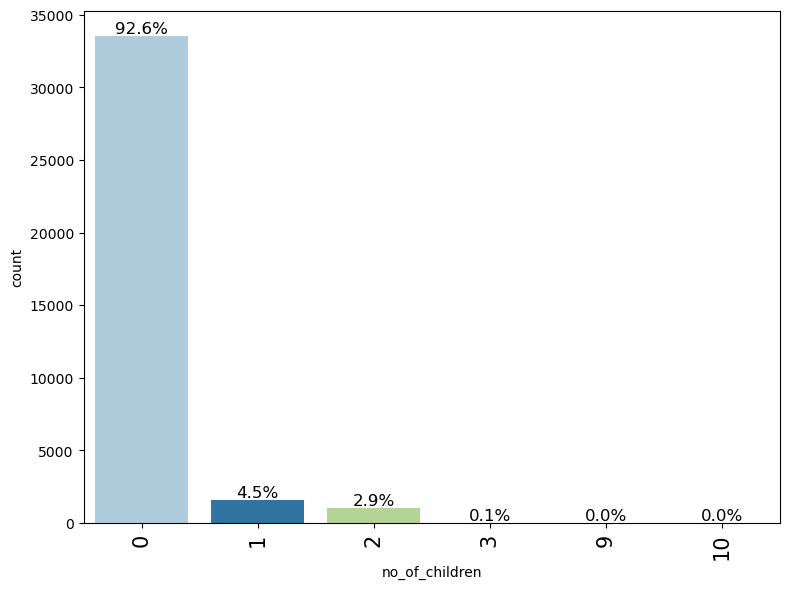

In [16]:
labeled_barplot(df_Inn, 'no_of_children', perc=True)

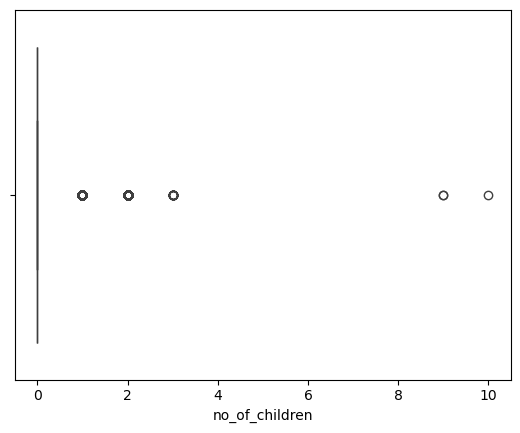

In [17]:
sns.boxplot(df_Inn, x = 'no_of_children')
plt.show()

In [18]:
df_Inn['no_of_weekend_nights'].value_counts()

no_of_weekend_nights
0    16872
1     9995
2     9071
3      153
4      129
5       34
6       20
7        1
Name: count, dtype: int64

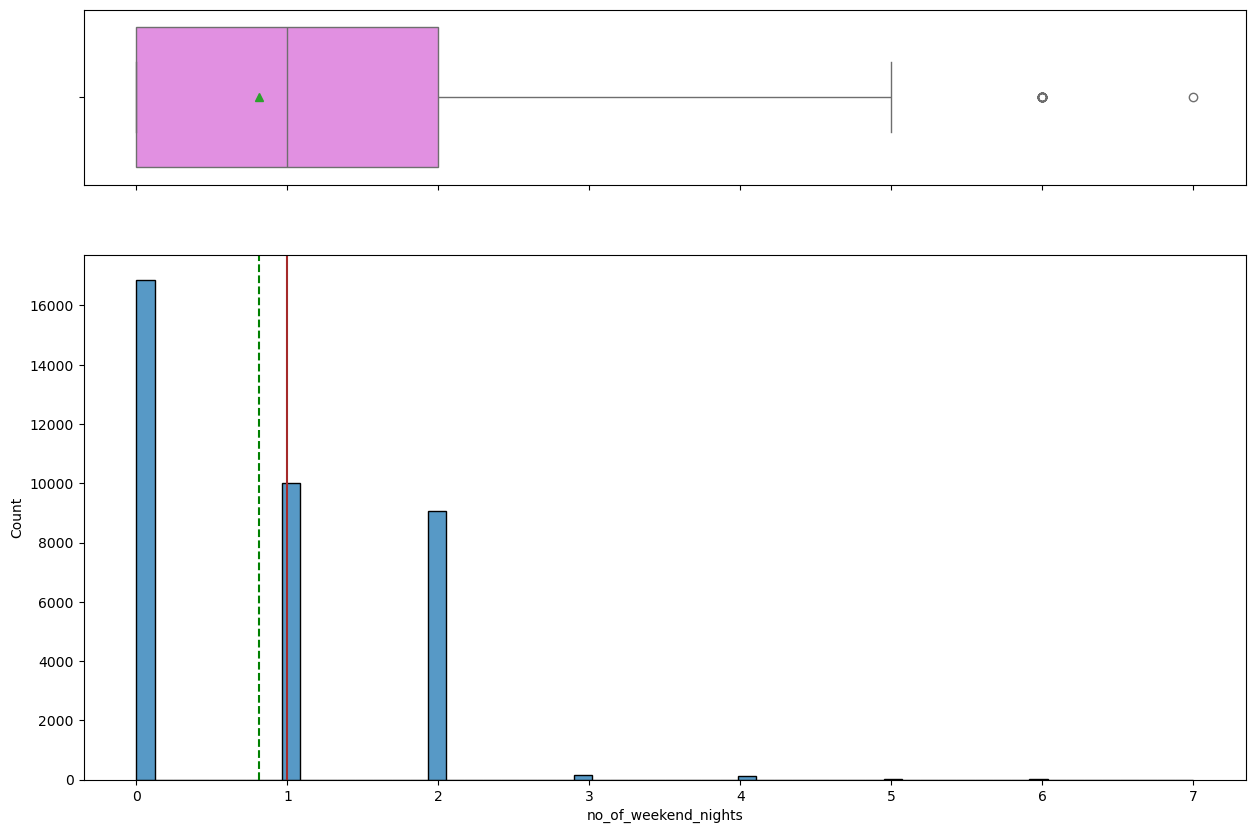

In [19]:
histogram_boxplot(df_Inn, 'no_of_weekend_nights')

In [20]:
df_Inn['no_of_week_nights'].value_counts()

no_of_week_nights
2     11444
1      9488
3      7839
4      2990
0      2387
5      1614
6       189
7       113
10       62
8        62
9        34
11       17
15       10
12        9
14        7
13        5
17        3
16        2
Name: count, dtype: int64

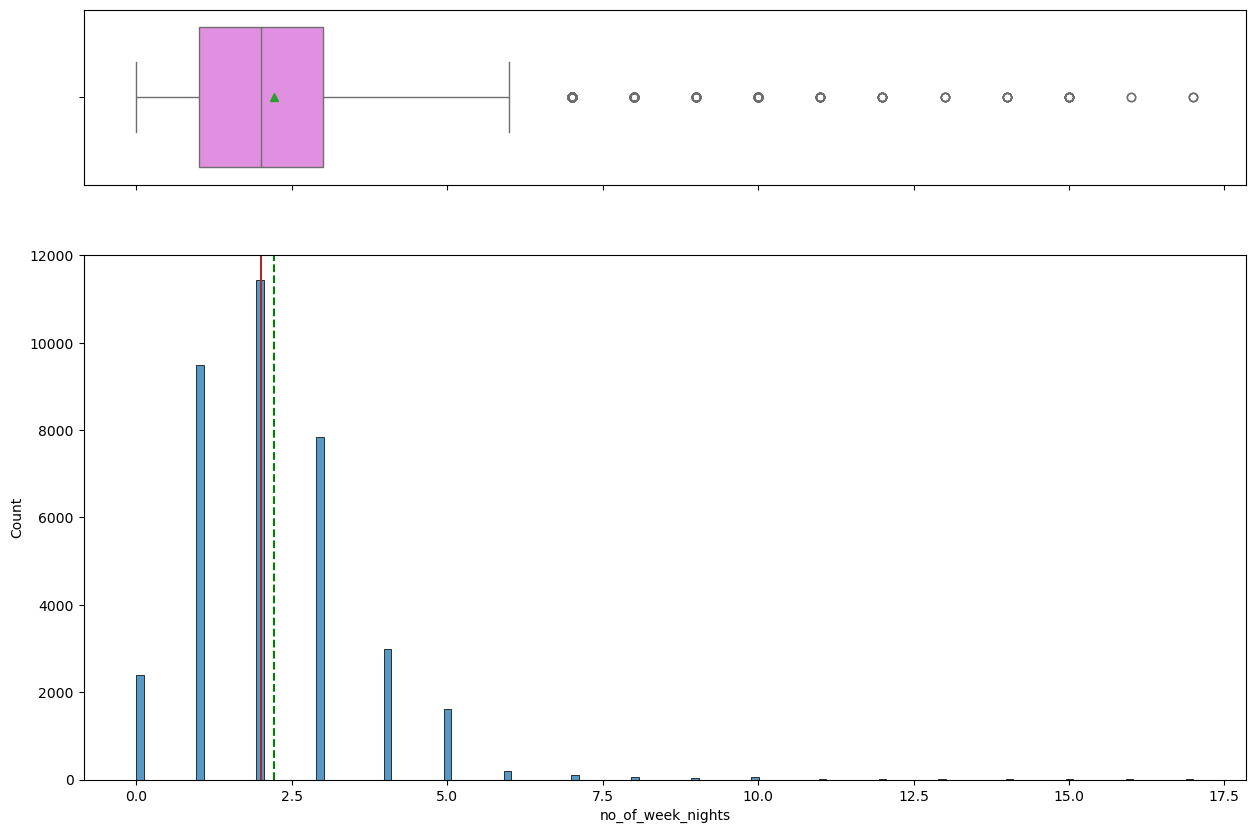

In [21]:
histogram_boxplot(df_Inn, 'no_of_week_nights')

In [22]:
df_Inn['type_of_meal_plan'].value_counts(), df_Inn['type_of_meal_plan'].value_counts(normalize = True)

(type_of_meal_plan
 Meal Plan 1     27835
 Not Selected     5130
 Meal Plan 2      3305
 Meal Plan 3         5
 Name: count, dtype: int64,
 type_of_meal_plan
 Meal Plan 1     0.767333
 Not Selected    0.141420
 Meal Plan 2     0.091110
 Meal Plan 3     0.000138
 Name: proportion, dtype: float64)

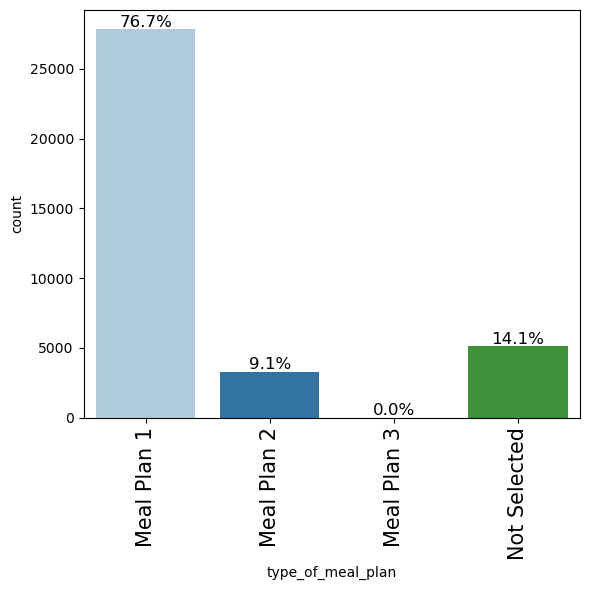

In [23]:
MP_order = ['Meal Plan 1', 'Meal Plan 2', 'Meal Plan 3', 'Not Selected']
labeled_barplot(df_Inn, 'type_of_meal_plan', custom_order=MP_order, perc=True)

In [24]:
df_Inn['required_car_parking_space'].value_counts(), df_Inn['required_car_parking_space'].value_counts(normalize=True)

(required_car_parking_space
 0    35151
 1     1124
 Name: count, dtype: int64,
 required_car_parking_space
 0    0.969014
 1    0.030986
 Name: proportion, dtype: float64)

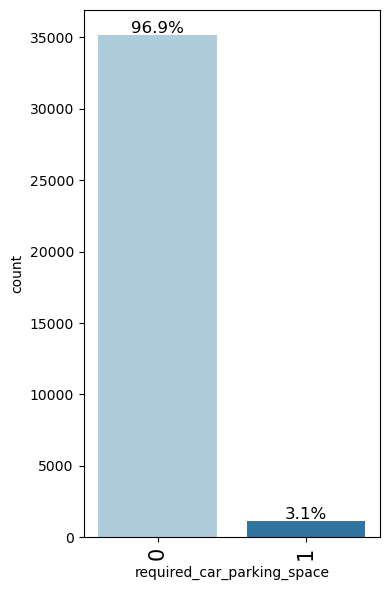

In [25]:
labeled_barplot(df_Inn, 'required_car_parking_space', perc=True)

In [26]:
df_Inn['room_type_reserved'].value_counts(), df_Inn['room_type_reserved'].value_counts(normalize=True)

(room_type_reserved
 Room_Type 1    28130
 Room_Type 4     6057
 Room_Type 6      966
 Room_Type 2      692
 Room_Type 5      265
 Room_Type 7      158
 Room_Type 3        7
 Name: count, dtype: int64,
 room_type_reserved
 Room_Type 1    0.775465
 Room_Type 4    0.166975
 Room_Type 6    0.026630
 Room_Type 2    0.019076
 Room_Type 5    0.007305
 Room_Type 7    0.004356
 Room_Type 3    0.000193
 Name: proportion, dtype: float64)

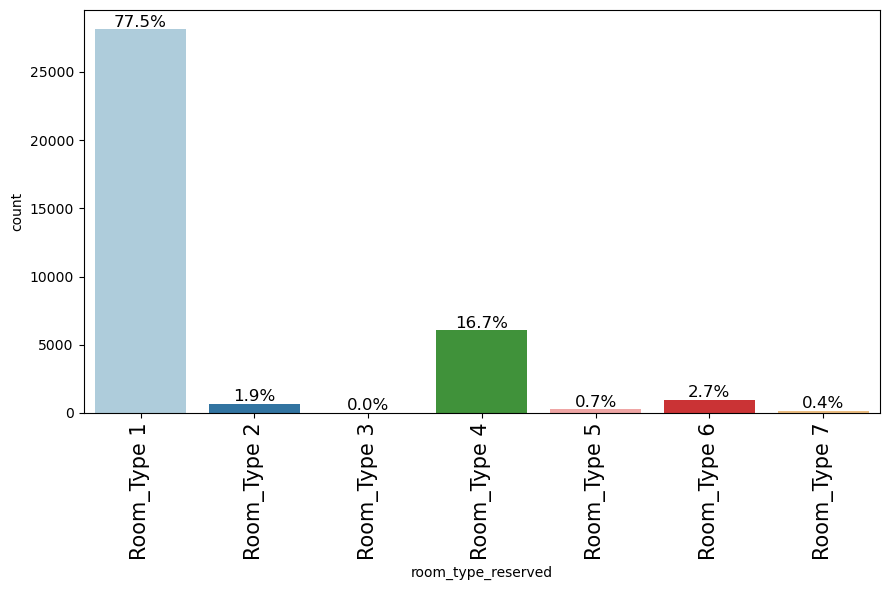

In [27]:
RT_order = ['Room_Type 1', 'Room_Type 2', 'Room_Type 3', 'Room_Type 4', 'Room_Type 5', 'Room_Type 6', 'Room_Type 7']
labeled_barplot(df_Inn, 'room_type_reserved', custom_order = RT_order, perc=True)

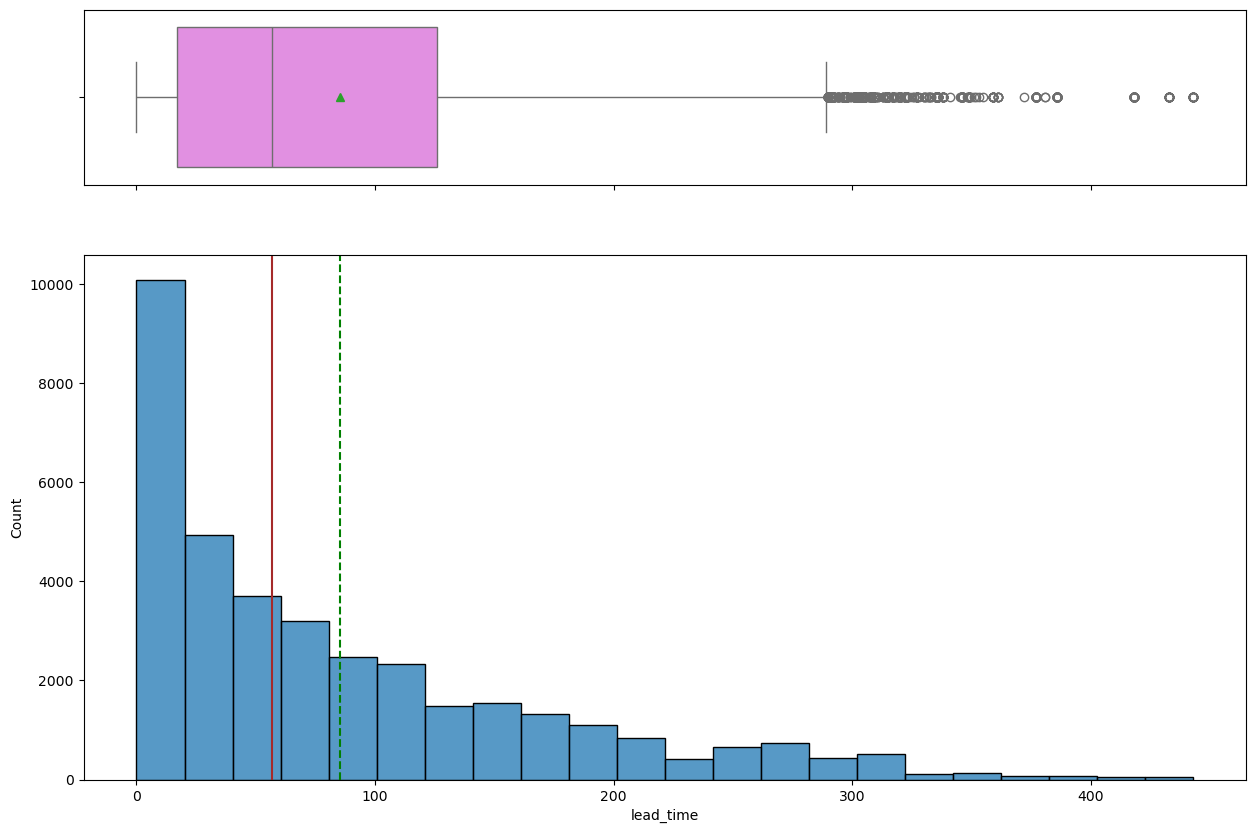

In [28]:
histogram_boxplot(df_Inn, 'lead_time', bins = 22)

In [29]:
df_Inn['arrival_year'].value_counts(), df_Inn['arrival_year'].value_counts(normalize=True)

(arrival_year
 2018    29761
 2017     6514
 Name: count, dtype: int64,
 arrival_year
 2018    0.820427
 2017    0.179573
 Name: proportion, dtype: float64)

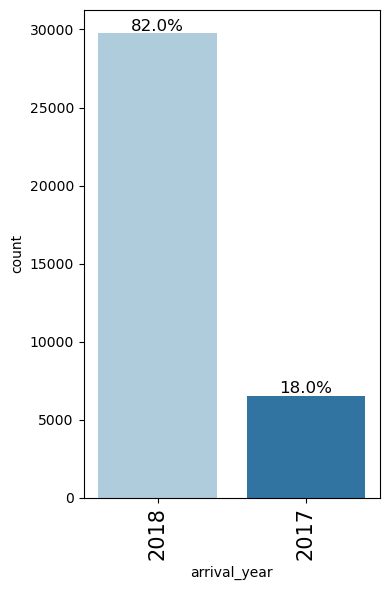

In [30]:
labeled_barplot(df_Inn, 'arrival_year', perc=True)

In [31]:
# It is better to treat year as a categorical column
df_Inn['arrival_year'] = pd.Categorical(df_Inn['arrival_year'])

In [32]:
# Break up the data by year
month_year_count = df_Inn.groupby(['arrival_year', 'arrival_month']).size().unstack(fill_value=0)
month_year_count

arrival_month,1,2,3,4,5,6,7,8,9,10,11,12
arrival_year,,,,,,,,,,,,
2017,0,0,0,0,0,0,363,1014,1649,1913,647,928
2018,1014,1704,2358,2736,2598,3203,2557,2799,2962,3404,2333,2093


In [33]:
# Full data is available only for 2018. 2017 has partial data.
# Make 2018 as the first row so that it is plotted at the base of the bars
# This makes it easier to analyze the busiest month
month_year_count = month_year_count.reindex([2018, 2017], axis = 0)

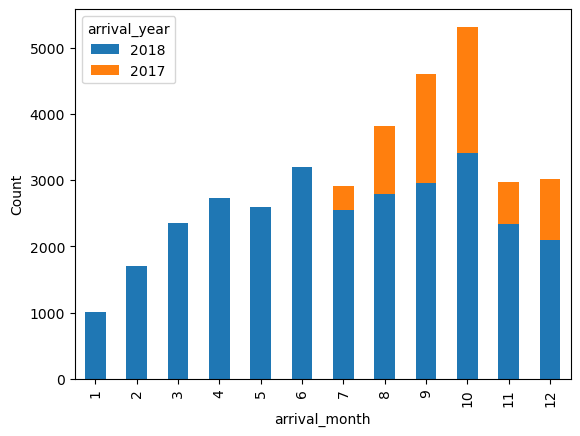

In [34]:
month_year_count.T.plot(kind='bar', stacked=True)
plt.ylabel('Count')
plt.show()

In [35]:
# It is better to treat month as a categorical column
df_Inn['arrival_month'] = pd.Categorical(df_Inn['arrival_month'])

In [36]:
df_Inn['arrival_date'].value_counts()

arrival_date
13    1358
17    1345
2     1331
4     1327
19    1327
16    1306
20    1281
15    1273
6     1273
18    1260
14    1242
30    1216
12    1204
8     1198
29    1190
21    1158
5     1154
26    1146
25    1146
1     1133
9     1130
28    1129
7     1110
24    1103
11    1098
3     1098
10    1089
27    1059
22    1023
23     990
31     578
Name: count, dtype: int64

In [37]:
df_Inn.drop('arrival_date', axis=1, inplace=True)
df_Inn

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,Online,0,0,0,167.80,1,Not_Canceled
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,Online,0,0,0,90.95,2,Canceled
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,Online,0,0,0,98.39,2,Not_Canceled
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,Online,0,0,0,94.50,0,Canceled


In [38]:
df_Inn['market_segment_type'].value_counts(), df_Inn['market_segment_type'].value_counts(normalize=True)

(market_segment_type
 Online           23214
 Offline          10528
 Corporate         2017
 Complementary      391
 Aviation           125
 Name: count, dtype: int64,
 market_segment_type
 Online           0.639945
 Offline          0.290227
 Corporate        0.055603
 Complementary    0.010779
 Aviation         0.003446
 Name: proportion, dtype: float64)

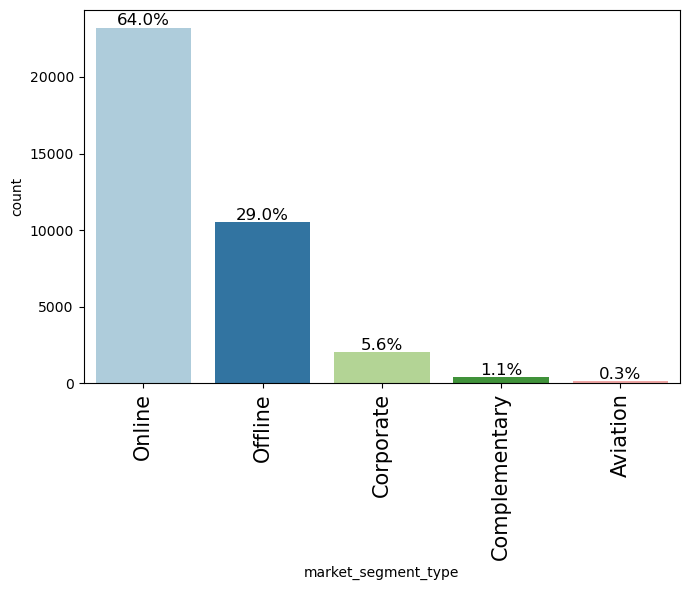

In [39]:
labeled_barplot(df_Inn, 'market_segment_type', perc=True)

In [40]:
df_Inn['repeated_guest'].value_counts(), df_Inn['repeated_guest'].value_counts(normalize=True)

(repeated_guest
 0    35345
 1      930
 Name: count, dtype: int64,
 repeated_guest
 0    0.974363
 1    0.025637
 Name: proportion, dtype: float64)

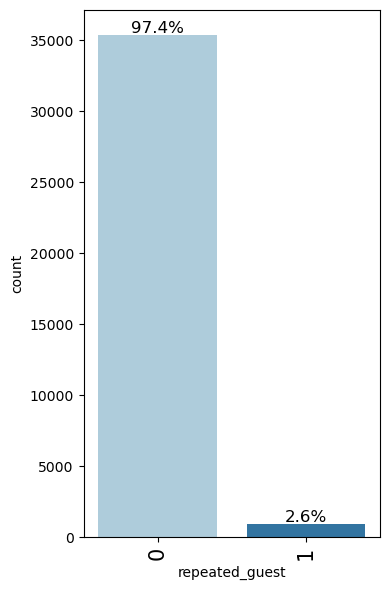

In [41]:
labeled_barplot(df_Inn, 'repeated_guest', perc=True)

In [42]:
df_Inn['no_of_previous_cancellations'].value_counts(), df_Inn['no_of_previous_cancellations'].value_counts(normalize=True)

(no_of_previous_cancellations
 0     35937
 1       198
 2        46
 3        43
 11       25
 5        11
 4        10
 13        4
 6         1
 Name: count, dtype: int64,
 no_of_previous_cancellations
 0     0.990682
 1     0.005458
 2     0.001268
 3     0.001185
 11    0.000689
 5     0.000303
 4     0.000276
 13    0.000110
 6     0.000028
 Name: proportion, dtype: float64)

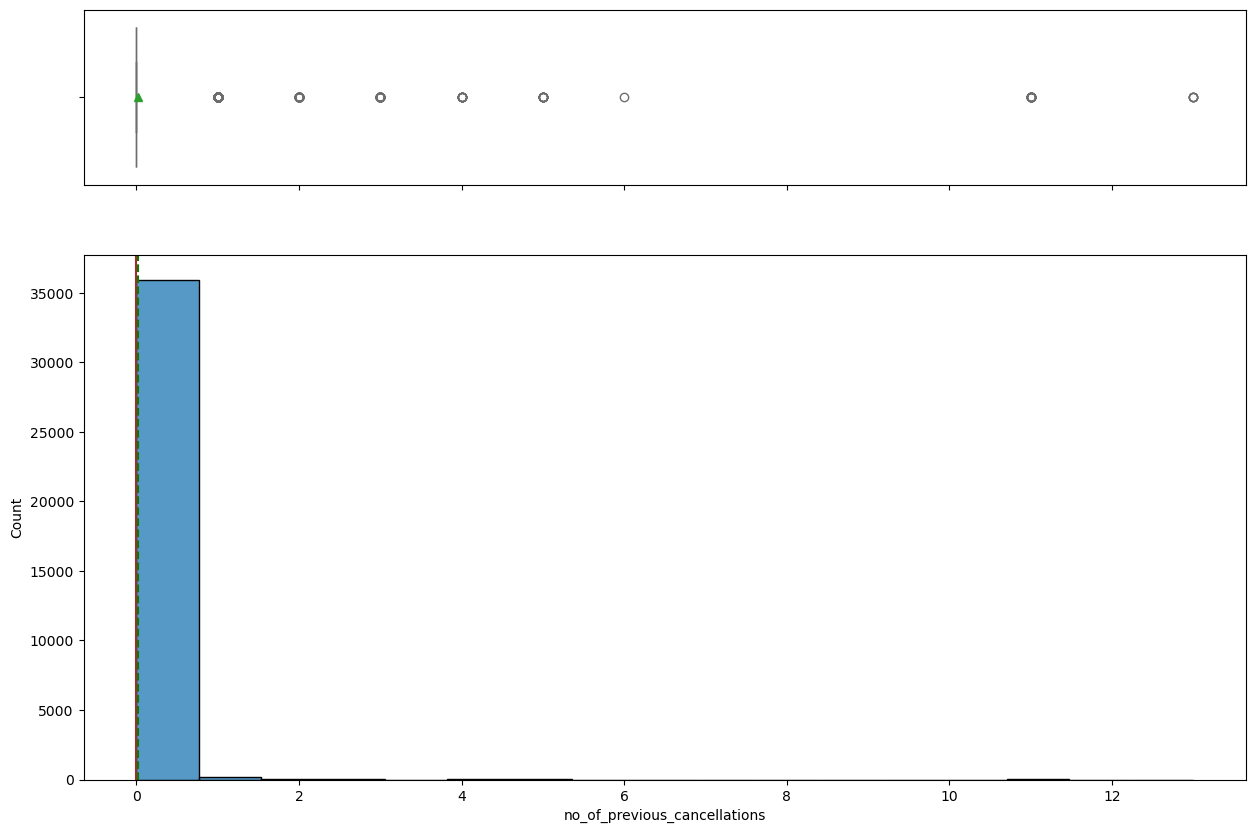

In [43]:
histogram_boxplot(df_Inn, 'no_of_previous_cancellations')

In [44]:
# Convert all non zero values to 1
df_Inn['no_of_previous_cancellations'] = df_Inn['no_of_previous_cancellations'].astype(bool).astype(int)
df_Inn['no_of_previous_cancellations'].value_counts()

no_of_previous_cancellations
0    35937
1      338
Name: count, dtype: int64

In [45]:
df_Inn['no_of_previous_bookings_not_canceled'].value_counts(), df_Inn['no_of_previous_bookings_not_canceled'].value_counts(normalize=True)

(no_of_previous_bookings_not_canceled
 0     35463
 1       228
 2       112
 3        80
 4        65
 5        60
 6        36
 7        24
 8        23
 10       19
 9        19
 11       15
 12       12
 14        9
 15        8
 16        7
 13        7
 18        6
 20        6
 21        6
 17        6
 19        6
 22        6
 25        3
 27        3
 24        3
 23        3
 44        2
 29        2
 48        2
 28        2
 30        2
 32        2
 31        2
 26        2
 46        1
 55        1
 45        1
 57        1
 53        1
 54        1
 58        1
 41        1
 40        1
 43        1
 35        1
 50        1
 56        1
 33        1
 37        1
 42        1
 51        1
 38        1
 34        1
 39        1
 52        1
 49        1
 47        1
 36        1
 Name: count, dtype: int64,
 no_of_previous_bookings_not_canceled
 0     0.977615
 1     0.006285
 2     0.003088
 3     0.002205
 4     0.001792
 5     0.001654
 6     0.000992
 7     0.000662
 

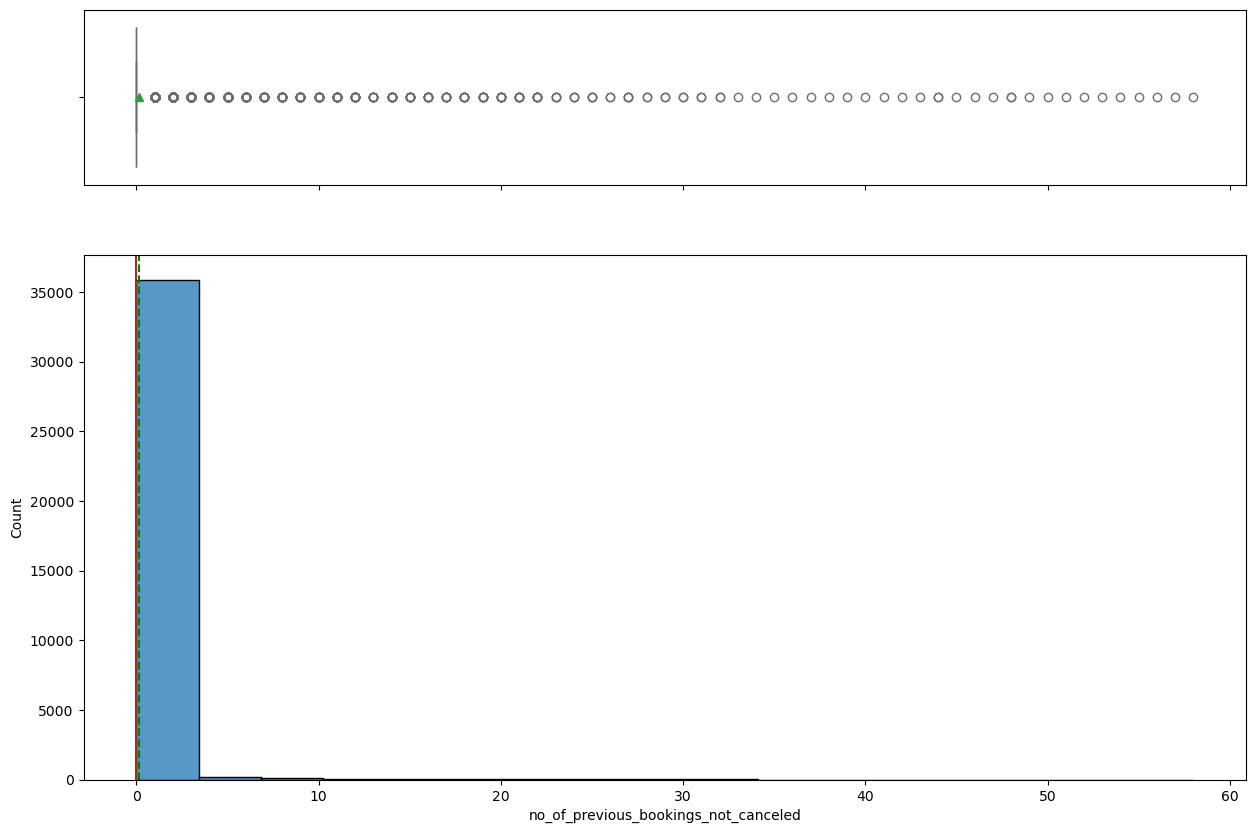

In [46]:
histogram_boxplot(df_Inn, 'no_of_previous_bookings_not_canceled')

In [47]:
# Convert all non zero values to 1
df_Inn['no_of_previous_bookings_not_canceled'] = df_Inn['no_of_previous_bookings_not_canceled'].astype(bool).astype(int)
df_Inn['no_of_previous_bookings_not_canceled'].value_counts()

no_of_previous_bookings_not_canceled
0    35463
1      812
Name: count, dtype: int64

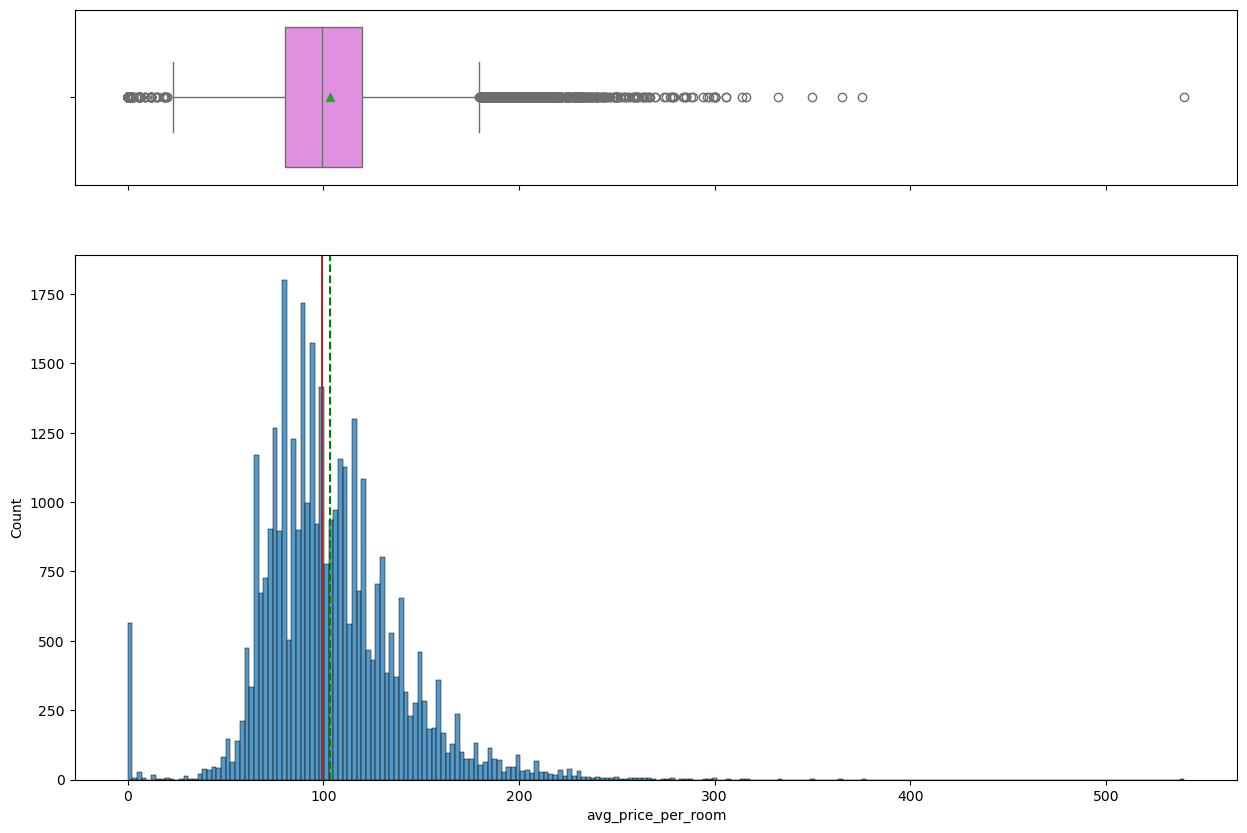

In [48]:
histogram_boxplot(df_Inn, 'avg_price_per_room')

In [49]:
df_Inn['no_of_special_requests'].value_counts(), df_Inn['no_of_special_requests'].value_counts(normalize=True)

(no_of_special_requests
 0    19777
 1    11373
 2     4364
 3      675
 4       78
 5        8
 Name: count, dtype: int64,
 no_of_special_requests
 0    0.545196
 1    0.313522
 2    0.120303
 3    0.018608
 4    0.002150
 5    0.000221
 Name: proportion, dtype: float64)

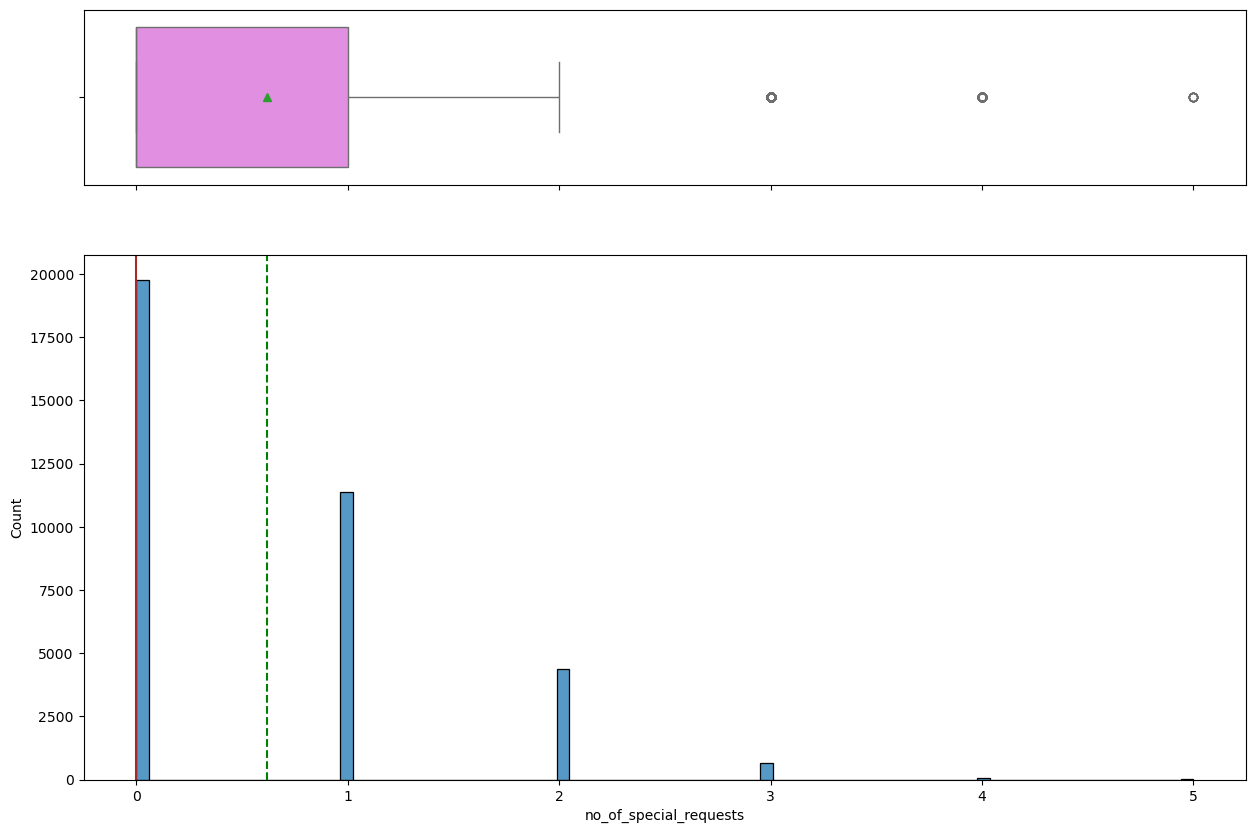

In [50]:
histogram_boxplot(df_Inn, 'no_of_special_requests')

In [51]:
df_Inn['booking_status'].value_counts(), df_Inn['booking_status'].value_counts(normalize=True)

(booking_status
 Not_Canceled    24390
 Canceled        11885
 Name: count, dtype: int64,
 booking_status
 Not_Canceled    0.672364
 Canceled        0.327636
 Name: proportion, dtype: float64)

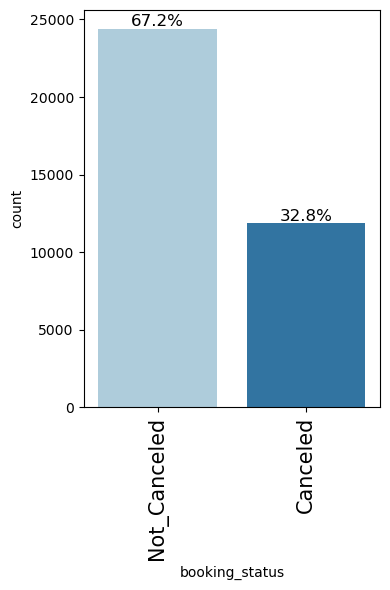

In [52]:
labeled_barplot(df_Inn, 'booking_status', perc=True)

In [53]:
df_Inn['booking_status'] = df_Inn['booking_status'].replace('Canceled', 1)
df_Inn['booking_status'] = df_Inn['booking_status'].replace('Not_Canceled', 0)
df_Inn['booking_status'].value_counts()

booking_status
0    24390
1    11885
Name: count, dtype: int64

### Bivariate analysis

In [54]:
df_Inn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          36275 non-null  int64   
 1   no_of_children                        36275 non-null  int64   
 2   no_of_weekend_nights                  36275 non-null  int64   
 3   no_of_week_nights                     36275 non-null  int64   
 4   type_of_meal_plan                     36275 non-null  object  
 5   required_car_parking_space            36275 non-null  int64   
 6   room_type_reserved                    36275 non-null  object  
 7   lead_time                             36275 non-null  int64   
 8   arrival_year                          36275 non-null  category
 9   arrival_month                         36275 non-null  category
 10  market_segment_type                   36275 non-null  object  
 11  re

In [55]:
numeric_columns = df_Inn.select_dtypes(include=['number']).columns.tolist()

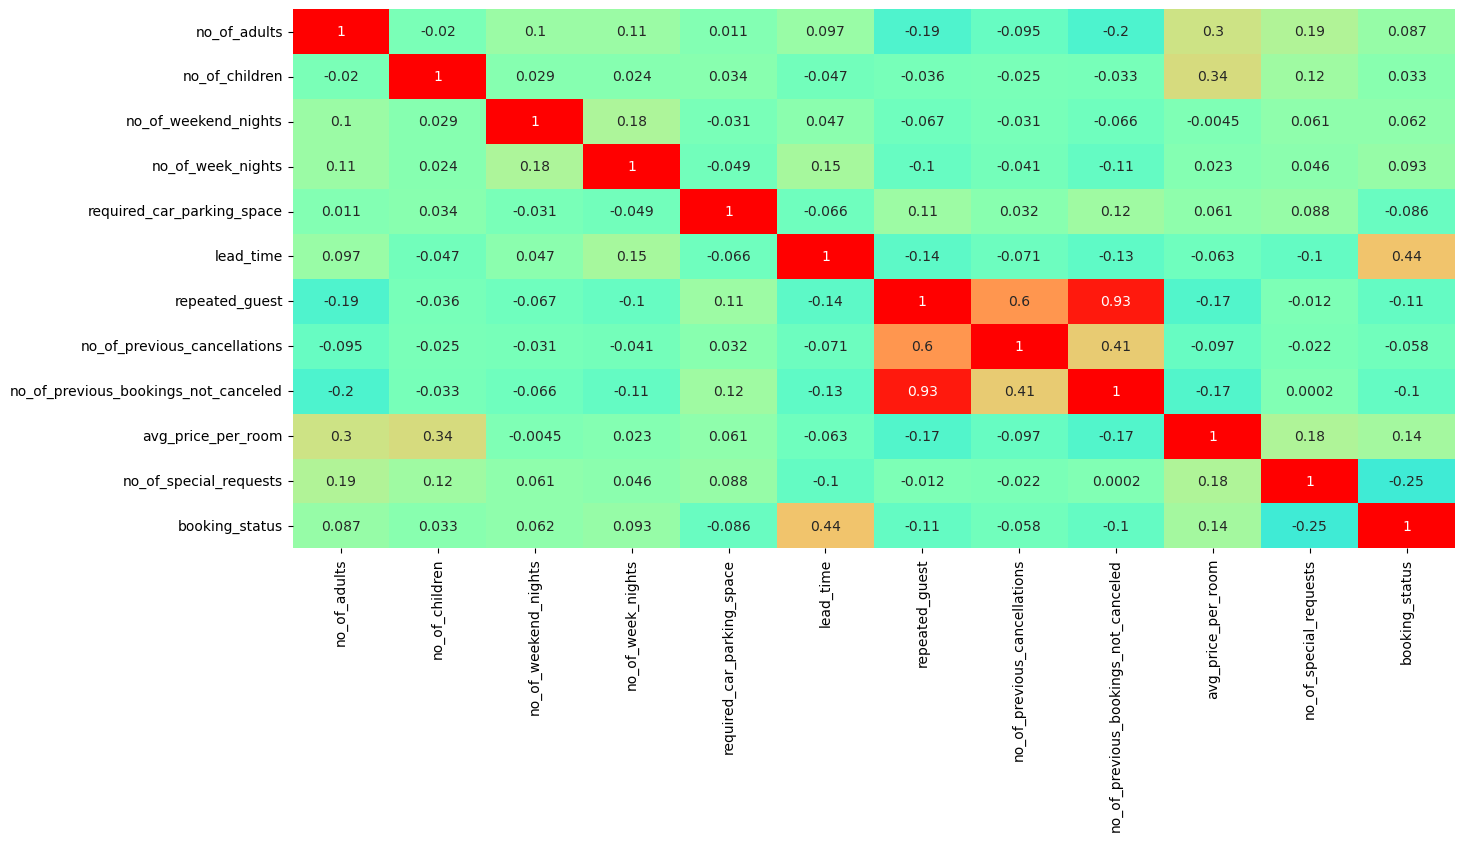

In [56]:
plt.figure(figsize=(15, 7))
sns.heatmap(df_Inn[numeric_columns].corr(), annot=True, vmax=1, vmin=-1, cmap='rainbow', cbar=False )
plt.show()

* Some of the features show high correlation. One of the highly correlated columns could be dropped to simplify the analysis.
* The numerical columns have been analyzed with a heatmap. The categorical columns in the data will be studied based on booking_status, since that is our point of interest. 

In [57]:
# Drop no_of_previous_bookings_not_canceled since it is correlated with multiple columns
df_Inn = df_Inn.drop('no_of_previous_bookings_not_canceled', axis = 1)

In [58]:
numeric_columns.remove('no_of_previous_bookings_not_canceled')

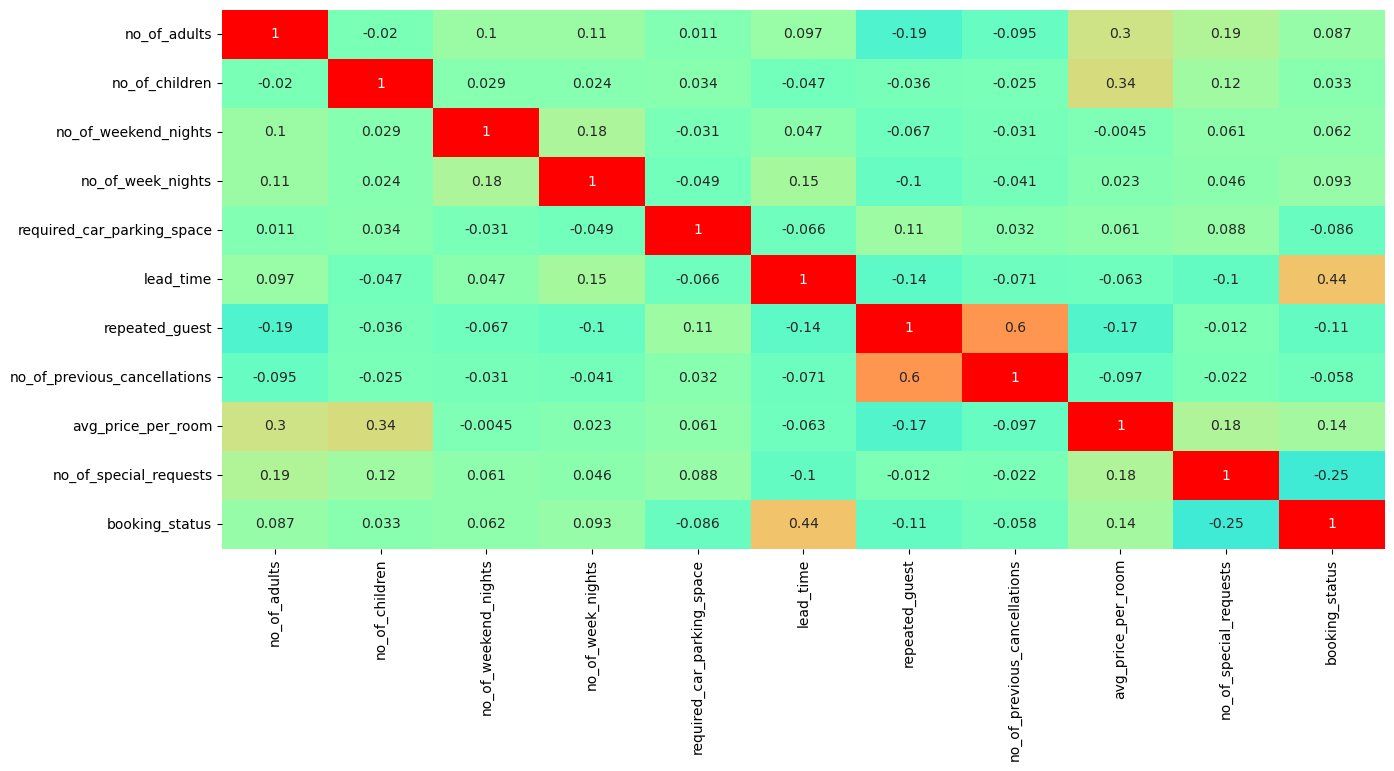

In [59]:
plt.figure(figsize=(15, 7))
sns.heatmap(df_Inn[numeric_columns].corr(), annot=True, vmax=1, vmin=-1, cmap='rainbow', cbar=False )
plt.show()

* We might have to drop one of repeated_guest or no_of_previous_cancellations. It can be done later based on VIF.

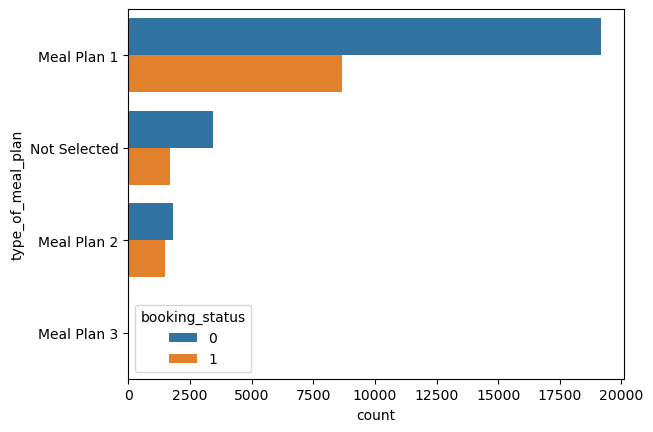

In [60]:
sns.countplot(data = df_Inn, y = 'type_of_meal_plan', hue = 'booking_status' )
plt.show()

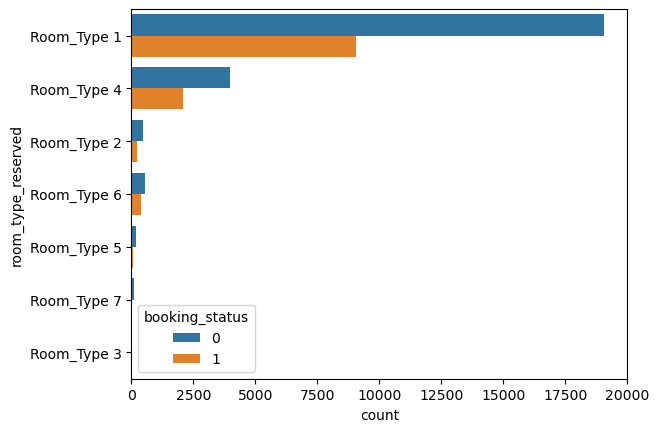

In [61]:
sns.countplot(data = df_Inn, y = 'room_type_reserved', hue = 'booking_status' )
plt.show()

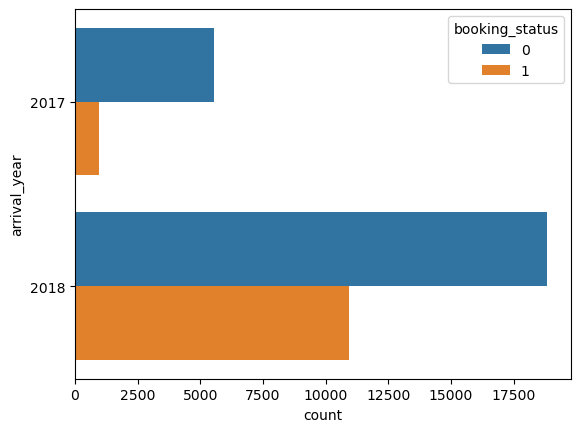

In [62]:
sns.countplot(data = df_Inn, y = 'arrival_year', hue = 'booking_status' )
plt.show()

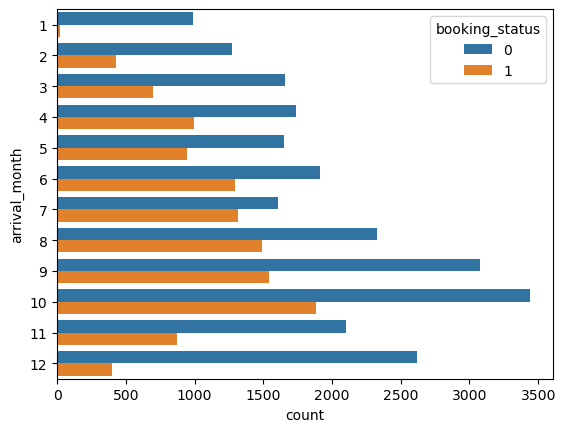

In [63]:
sns.countplot(data = df_Inn, y = 'arrival_month', hue = 'booking_status' )
plt.show()

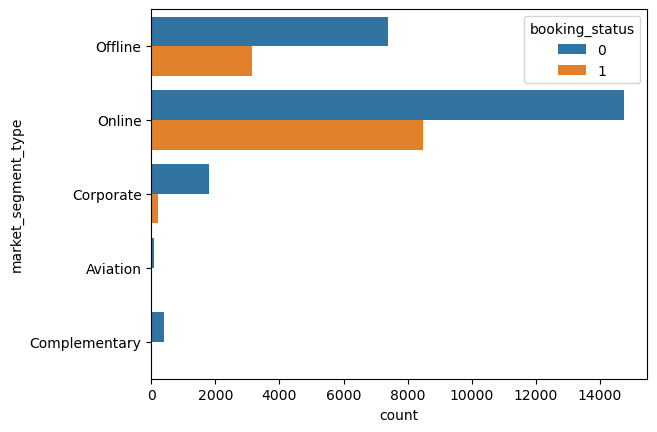

In [64]:
sns.countplot(data = df_Inn, y = 'market_segment_type', hue = 'booking_status')
plt.show()

### Answers to the EDA questions

#### 1. What are the busiest months in the hotel?

In [65]:
df_Inn.groupby(['arrival_year', 'arrival_month']).size().unstack()

arrival_month,1,2,3,4,5,6,7,8,9,10,11,12
arrival_year,,,,,,,,,,,,
2017,0,0,0,0,0,0,363,1014,1649,1913,647,928
2018,1014,1704,2358,2736,2598,3203,2557,2799,2962,3404,2333,2093


#### 2.	Which market segment do most of the guests come from?

In [66]:
df_Inn.groupby(['market_segment_type']).size()

market_segment_type
Aviation           125
Complementary      391
Corporate         2017
Offline          10528
Online           23214
dtype: int64

#### 3.	Hotel rates are dynamic and change according to demand and customer demographics. What are the differences in room prices in different market segments?

In [67]:
np.round( df_Inn.groupby(['market_segment_type'])['avg_price_per_room'].mean(), 2)

market_segment_type
Aviation         100.70
Complementary      3.14
Corporate         82.91
Offline           91.63
Online           112.26
Name: avg_price_per_room, dtype: float64

#### 4.	What percentage of bookings are cancelled?

In [68]:
pct_cancel = len ( df_Inn[ df_Inn['booking_status'] == 1 ] ) / len ( df_Inn['booking_status'] ) * 100
print('Percentage of cancellations = ', np.round(pct_cancel, 2))

Percentage of cancellations =  32.76


#### 5.	Repeating guests are the guests who stay in the hotel often and are important to brand equity. What percentage of repeating guests cancel?

In [69]:
df_Inn_RepeatingGuests = df_Inn[ df_Inn['repeated_guest'] == 1 ]
pct_rg_cal = len ( df_Inn_RepeatingGuests[ df_Inn_RepeatingGuests['booking_status'] == 1 ] ) / len ( df_Inn_RepeatingGuests['booking_status'] ) * 100
print('Percentage of cancellations for repeated guests = ', np.round(pct_rg_cal, 2))

Percentage of cancellations for repeated guests =  1.72


#### 6.	Many guests have special requirements when booking a hotel room. Do these requirements affect booking cancellation?

In [70]:
pd.crosstab(index=df_Inn['booking_status'], columns=df_Inn['no_of_special_requests'])

no_of_special_requests,0,1,2,3,4,5
booking_status,,,,,,
0,11232,8670,3727,675,78,8
1,8545,2703,637,0,0,0


In [71]:
pd.crosstab(index=df_Inn['booking_status'], columns=df_Inn['no_of_special_requests'], normalize='columns').round(2)

no_of_special_requests,0,1,2,3,4,5
booking_status,,,,,,
0,0.57,0.76,0.85,1.0,1.0,1.0
1,0.43,0.24,0.15,0.0,0.0,0.0


## Data Preprocessing

### Missing value treatment
There are no missing values.

### Outlier detection and treatment

* The high values in no_of_previous_cancellations and no_of_previous_bookings_not_canceled were converted to 1.
* Most of the columns contain outliers. However, they have not been treated. 

### Feature engineering

* arrival_year and arrival_month have been converted to a category column
* One hot encoding will be performed for category / object columns

In [72]:
df_Inn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   no_of_adults                  36275 non-null  int64   
 1   no_of_children                36275 non-null  int64   
 2   no_of_weekend_nights          36275 non-null  int64   
 3   no_of_week_nights             36275 non-null  int64   
 4   type_of_meal_plan             36275 non-null  object  
 5   required_car_parking_space    36275 non-null  int64   
 6   room_type_reserved            36275 non-null  object  
 7   lead_time                     36275 non-null  int64   
 8   arrival_year                  36275 non-null  category
 9   arrival_month                 36275 non-null  category
 10  market_segment_type           36275 non-null  object  
 11  repeated_guest                36275 non-null  int64   
 12  no_of_previous_cancellations  36275 non-null  

### Data scaling

* Data scaling has not been performed.

### Test train split

In [73]:
X = df_Inn.drop('booking_status', axis = 1)
y = df_Inn['booking_status']

# Add constant and create dummies
X = pd.get_dummies(X)

# Drop one significant value from each categorical column so that there is a baseline which is easy to interpret.
X = X.drop(['type_of_meal_plan_Meal Plan 1', 'room_type_reserved_Room_Type 1', 'arrival_year_2018', 'arrival_month_10', 'market_segment_type_Online'], axis = 1)

X = X.astype(float)
X = add_constant(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

## Model building

### Logistic regression

In [74]:
logit = sm.Logit(y_train, X_train)

In [75]:
lg = logit.fit()

         Current function value: 0.409647
         Iterations: 35


E:\Software\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [76]:
lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25356
Method:                           MLE   Df Model:                           35
Date:                Mon, 24 Mar 2025   Pseudo R-squ.:                  0.3523
Time:                        10:19:27   Log-Likelihood:                -10402.
converged:                      False   LL-Null:                       -16060.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -2.9039      0.137    -21.186      0.000      -3.173      -2.635
no_of_adults                          0.0898      0.039      2.295      0.022       0.013       0.167
no_of_children                        0.1525      0.064      2.388      0.017       0.027       0.278
no_of_weekend_nights                  0.1581      0.020      7.776      0.000       0.118       0.198
no_of_week_nights                     0.0462      0.013      3.636      0.000       0.021       0.071
required_car_parking_space           -1.6057      0.139    -11.545      0.000      -1.878      -1.333
lead_time                             0.0162      0.000     55.739      0.000       0.016       0.017
repeated_guest                      -13.6595    178.949     -0.076      0.939    -364.394     337.075
no_of_previous_cancellations         12.5829    178.950      0.070      0.944    -338.152     363.318
avg_price_per_room                    0.0183      0.001     21.760      0.000       0.017       0.020
no_of_special_requests               -1.5450      0.031    -49.601      0.000      -1.606      -1.484
type_of_meal_plan_Meal Plan 2         0.2216      0.069      3.213      0.001       0.086       0.357
type_of_meal_plan_Meal Plan 3        23.9726   9.77e+04      0.000      1.000   -1.92e+05    1.92e+05
type_of_meal_plan_Not Selected        0.2027      0.054      3.722      0.000       0.096       0.309
room_type_reserved_Room_Type 2       -0.3782      0.139     -2.729      0.006      -0.650      -0.107
room_type_reserved_Room_Type 3        1.0158      1.876      0.541      0.588      -2.661       4.693
room_type_reserved_Room_Type 4       -0.2591      0.054     -4.797      0.000      -0.365      -0.153
room_type_reserved_Room_Type 5       -0.7671      0.219     -3.500      0.000      -1.197      -0.337
room_type_reserved_Room_Type 6       -0.8473      0.158     -5.352      0.000      -1.158      -0.537
room_type_reserved_Room_Type 7       -1.3893      0.304     -4.564      0.000      -1.986      -0.793
arrival_year_2017                    -0.4796      0.064     -7.460      0.000      -0.606      -0.354
arrival_month_1                      -2.4377      0.281     -8.683      0.000      -2.988      -1.887
arrival_month_2                       0.6367      0.096      6.608      0.000       0.448       0.826
arrival_month_3                       0.2322      0.085      2.726      0.006       0.065       0.399
arrival_month_4                      -0.0133      0.078     -0.171      0.864      -0.165       0.139
arrival_month_5                      -0.3738      0.079     -4.718      0.000      -0.529      -0.219
arrival_month_6                      -0.0743      0.074     -1.004      0.315      -0.219       0.071
arrival_month_7                      -0.1595      0.075     -2.123      0.034      -0.307      -0.012
arrival_month_8                      -0.2787      0.072     -3.848      0.000  

* Multicollinearity is one of the reasons for the failure to converge. The columns with high VIF needs to be dropped one at a time. 

#### Multicollinearity treatment

In [77]:
vif = pd.Series( [ variance_inflation_factor(X_train.values, i) for i in range( X_train.shape[1] ) ], 
               index=X_train.columns)
vif

const                                55.117215
no_of_adults                          1.384449
no_of_children                        2.038176
no_of_weekend_nights                  1.074770
no_of_week_nights                     1.104019
required_car_parking_space            1.041404
lead_time                             1.546975
repeated_guest                        1.948474
no_of_previous_cancellations          1.555019
avg_price_per_room                    2.505475
no_of_special_requests                1.248699
type_of_meal_plan_Meal Plan 2         1.280066
type_of_meal_plan_Meal Plan 3         1.008521
type_of_meal_plan_Not Selected        1.287680
room_type_reserved_Room_Type 2        1.096308
room_type_reserved_Room_Type 3        1.004281
room_type_reserved_Room_Type 4        1.360665
room_type_reserved_Room_Type 5        1.032296
room_type_reserved_Room_Type 6        2.019109
room_type_reserved_Room_Type 7        1.096202
arrival_year_2017                     1.571806
arrival_month

In [78]:
# Drop columns which have vif > 5 one by one
while True:
    col_to_drop = vif.idxmax()
    X_train = X_train.drop(col_to_drop, axis = 1)
    vif = pd.Series( [ variance_inflation_factor(X_train.values, i) for i in range( X_train.shape[1] ) ], index=X_train.columns)
    if max(vif) < 5:
        break

vif

no_of_children                       2.096151
no_of_weekend_nights                 1.907268
no_of_week_nights                    3.502009
required_car_parking_space           1.068890
lead_time                            2.430130
repeated_guest                       1.982575
no_of_previous_cancellations         1.568832
no_of_special_requests               1.781720
type_of_meal_plan_Meal Plan 2        1.310088
type_of_meal_plan_Meal Plan 3        1.008496
type_of_meal_plan_Not Selected       1.289154
room_type_reserved_Room_Type 2       1.109802
room_type_reserved_Room_Type 3       1.004282
room_type_reserved_Room_Type 4       1.359355
room_type_reserved_Room_Type 5       1.026708
room_type_reserved_Room_Type 6       1.886556
room_type_reserved_Room_Type 7       1.057261
arrival_year_2017                    1.495476
arrival_month_1                      1.101181
arrival_month_2                      1.175287
arrival_month_3                      1.249177
arrival_month_4                   

In [79]:
# Add the constant back into the model
X_train = add_constant(X_train)
lg = sm.Logit(y_train, X_train.astype(float)).fit()

         Current function value: 0.420393
         Iterations: 35


E:\Software\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [80]:
lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25358
Method:                           MLE   Df Model:                           33
Date:                Mon, 24 Mar 2025   Pseudo R-squ.:                  0.3353
Time:                        10:19:33   Log-Likelihood:                -10675.
converged:                      False   LL-Null:                       -16060.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -0.4510      0.070     -6.414      0.000      -0.589      -0.313
no_of_children                        0.3173      0.059      5.405      0.000       0.202       0.432
no_of_weekend_nights                  0.1148      0.020      5.761      0.000       0.076       0.154
no_of_week_nights                     0.0350      0.012      2.799      0.005       0.010       0.059
required_car_parking_space           -1.3757      0.138     -9.981      0.000      -1.646      -1.106
lead_time                             0.0142      0.000     54.018      0.000       0.014       0.015
repeated_guest                      -15.1573    325.799     -0.047      0.963    -653.711     623.397
no_of_previous_cancellations         13.7419    325.799      0.042      0.966    -624.813     652.297
no_of_special_requests               -1.5033      0.031    -49.059      0.000      -1.563      -1.443
type_of_meal_plan_Meal Plan 2         0.6570      0.064     10.189      0.000       0.531       0.783
type_of_meal_plan_Meal Plan 3        19.8578   4593.386      0.004      0.997   -8983.013    9022.728
type_of_meal_plan_Not Selected       -0.0226      0.053     -0.429      0.668      -0.126       0.081
room_type_reserved_Room_Type 2       -0.5646      0.136     -4.153      0.000      -0.831      -0.298
room_type_reserved_Room_Type 3        0.6821      1.839      0.371      0.711      -2.921       4.286
room_type_reserved_Room_Type 4        0.1324      0.049      2.694      0.007       0.036       0.229
room_type_reserved_Room_Type 5       -0.2307      0.214     -1.077      0.282      -0.651       0.189
room_type_reserved_Room_Type 6        0.2893      0.144      2.013      0.044       0.008       0.571
room_type_reserved_Room_Type 7        0.1993      0.283      0.705      0.481      -0.355       0.753
arrival_year_2017                    -0.9206      0.061    -15.191      0.000      -1.039      -0.802
arrival_month_1                      -3.1146      0.279    -11.180      0.000      -3.661      -2.569
arrival_month_2                      -0.0331      0.090     -0.367      0.714      -0.210       0.144
arrival_month_3                      -0.2232      0.080     -2.775      0.006      -0.381      -0.066
arrival_month_4                      -0.3084      0.075     -4.106      0.000      -0.456      -0.161
arrival_month_5                      -0.3810      0.078     -4.894      0.000      -0.534      -0.228
arrival_month_6                      -0.0677      0.073     -0.933      0.351      -0.210       0.074
arrival_month_7                      -0.1931      0.074     -2.626      0.009      -0.337      -0.049
arrival_month_8                      -0.2537      0.071     -3.572      0.000      -0.393      -0.115
arrival_month_9                      -0.1290      0.068     -1.895      0.058      -0.262       0.004
arrival_month_11                      0.0108      0.079      0.137      0.891  

#### Drop insignificant features

In [81]:
# Keep dropping columns which have p value greater than 0.05
while True:
    col = lg.pvalues.idxmax()
    X_train = X_train.drop(col, axis = 1)
    lg = sm.Logit(y_train, X_train.astype(float)).fit()

    # Break the loop when all features have p values less than 0.05
    if max(lg.pvalues) < 0.05:
        break

lg.summary()

         Current function value: 0.420512
         Iterations: 35
         Current function value: 0.422124
         Iterations: 35


E:\Software\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Software\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.422336
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.422336
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.422337
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.422338
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.422339
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.422346
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.422364
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.422391
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.422460
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25369
Method:                           MLE   Df Model:                           22
Date:                Mon, 24 Mar 2025   Pseudo R-squ.:                  0.3321
Time:                        10:19:34   Log-Likelihood:                -10727.
converged:                       True   LL-Null:                       -16060.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.5446      0.047    -11.522      0.000      -0.637      -0.452
no_of_children                     0.3269      0.057      5.754      0.000       0.216       0.438
no_of_weekend_nights               0.1191      0.020      6.010      0.000       0.080       0.158
no_of_week_nights                  0.0372      0.012      2.998      0.003       0.013       0.062
required_car_parking_space        -1.3752      0.138     -9.997      0.000      -1.645      -1.106
lead_time                          0.0143      0.000     55.990      0.000       0.014       0.015
repeated_guest                    -2.4249      0.389     -6.238      0.000      -3.187      -1.663
no_of_special_requests            -1.4939      0.030    -49.239      0.000      -1.553      -1.434
type_of_meal_plan_Meal Plan 2      0.6485      0.064     10.090      0.000       0.523       0.775
room_type_reserved_Room_Type 2    -0.5640      0.135     -4.179      0.000      -0.829      -0.299
room_type_reserved_Room_Type 4     0.1442      0.046      3.106      0.002       0.053       0.235
room_type_reserved_Room_Type 6     0.2790      0.141      1.979      0.048       0.003       0.555
arrival_year_2017                 -0.9246      0.056    -16.389      0.000      -1.035      -0.814
arrival_month_1                   -3.0751      0.275    -11.190      0.000      -3.614      -2.537
arrival_month_3                   -0.1642      0.067     -2.460      0.014      -0.295      -0.033
arrival_month_4                   -0.2499      0.061     -4.080      0.000      -0.370      -0.130
arrival_month_5                   -0.3281      0.065     -5.064      0.000      -0.455      -0.201
arrival_month_7                   -0.1360      0.062     -2.209      0.027      -0.257      -0.015
arrival_month_8                   -0.2034      0.059     -3.470      0.001      -0.318      -0.089
arrival_month_12                  -1.8107      0.088    -20.478      0.000      -1.984      -1.637
market_segment_type_Aviation      -0.5682      0.254     -2.237      0.025      -1.066      -0.070
market_segment_type_Corporate     -1.1682      0.101    -11.601      0.000      -1.366      -0.971
market_segment_type_Offline       -1.9856      0.050    -39.667      0.000      -2.084      -1.888
==================================================================================================
"""

In [82]:
droppedCols = [ col for col in X_test.columns if col not in X_train.columns ]
droppedCols

['no_of_adults',
 'no_of_previous_cancellations',
 'avg_price_per_room',
 'type_of_meal_plan_Meal Plan 3',
 'type_of_meal_plan_Not Selected',
 'room_type_reserved_Room_Type 3',
 'room_type_reserved_Room_Type 5',
 'room_type_reserved_Room_Type 7',
 'arrival_month_2',
 'arrival_month_6',
 'arrival_month_9',
 'arrival_month_11',
 'market_segment_type_Complementary']

#### Interpret coefficients

In [83]:
# Odds ratio
odds_ratio = np.exp(lg.params)

# Percentage change in odds
pct_change_odds = 100 * (np.exp(lg.params) - 1)

# adding the odds to a dataframe
odds_df = pd.DataFrame({"Odds_Ratio": odds_ratio, "Change in Odds %": pct_change_odds}, index=X_train.columns)
odds_df

,Odds_Ratio,Change in Odds %
const,0.580100,-41.990046
no_of_children,1.386635,38.663536
no_of_weekend_nights,1.126489,12.648911
no_of_week_nights,1.037898,3.789802
required_car_parking_space,0.252784,-74.721558
lead_time,1.014411,1.441053
repeated_guest,0.088483,-91.151704
no_of_special_requests,0.224490,-77.551021
type_of_meal_plan_Meal Plan 2,1.912746,91.274648
room_type_reserved_Room_Type 2,0.568940,-43.105970


#### Model performance across different metrics - Default threshold of 0.5

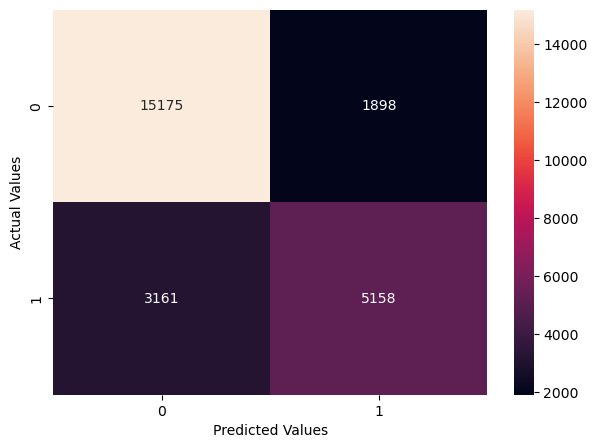

Accuracy score =  0.8
Recall score =  0.62
Precision score =  0.73
F1 score =  0.67


In [84]:
# Training set performance
y_pred_train = lg.predict(X_train)

# Confusion matrix
create_confusion_matrix(y_train, np.round(y_pred_train))
dict_train_def = print_performance_metrics(y_train, np.round(y_pred_train))

In [85]:
X_test = X_test.drop(droppedCols, axis = 1)

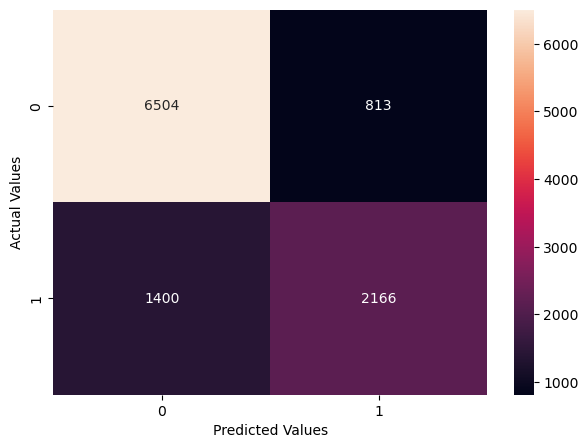

Accuracy score =  0.8
Recall score =  0.61
Precision score =  0.73
F1 score =  0.66


In [86]:
# Default threshold of 0.5
y_pred_test = lg.predict(X_test) > 0.5

# Confusion matrix on test
create_confusion_matrix(y_test, y_pred_test)
dict_test_def = print_performance_metrics(y_test, np.round(y_pred_test))

#### Model based on optimal threshold value from the AUC-ROC curve

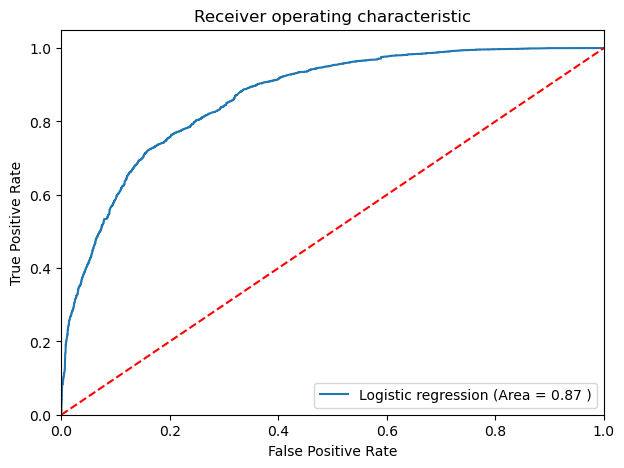

In [87]:
# ROC AUC curve
logit_roc_auc_train = roc_auc_score(y_train, y_pred_train)
fpr, tpr, roc_thresholds = roc_curve(y_train, y_pred_train)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label = 'Logistic regression (Area = %.2f )' % logit_roc_auc_train )
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [88]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
#fpr, tpr, thresholds = roc_curve(y_train, y_pred)
optimal_idx_roc = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = roc_thresholds[optimal_idx_roc]
print(optimal_threshold_auc_roc)

0.40644187868121034


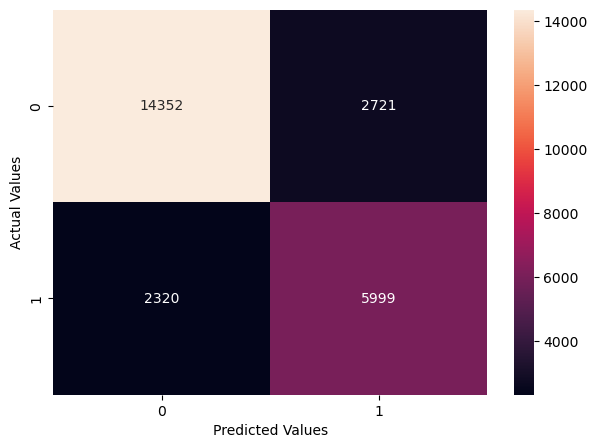

Accuracy score =  0.8
Recall score =  0.72
Precision score =  0.69
F1 score =  0.7


In [89]:
# Prediction on training data
y_pred_train_ROC = np.round( lg.predict(X_train) > optimal_threshold_auc_roc)

# Confusion matrix
create_confusion_matrix(y_train, y_pred_train_ROC)
dict_train_ROC = print_performance_metrics(y_train, y_pred_train_ROC)

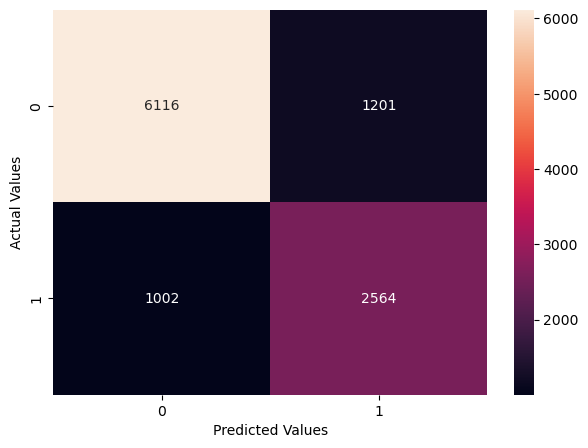

Accuracy score =  0.8
Recall score =  0.72
Precision score =  0.68
F1 score =  0.7


In [90]:
# Use test data
y_pred_test_ROC = np.round( lg.predict(X_test) > optimal_threshold_auc_roc )
create_confusion_matrix(y_test, y_pred_test_ROC)
dict_test_ROC = print_performance_metrics(y_test, y_pred_test_ROC)

#### Model based on Precision-Recall curve 

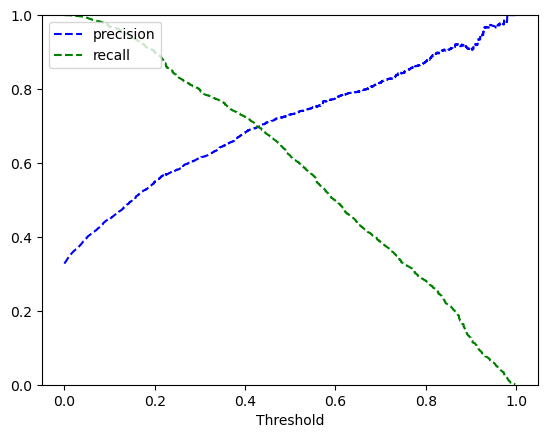

In [91]:
precisions, recalls, thresholds_PR = precision_recall_curve(y_train, y_pred_train)

plt.plot(thresholds_PR, precisions[:-1], "b--", label="precision")
plt.plot(thresholds_PR, recalls[:-1], "g--", label="recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

In [92]:
opt_idx_PR = np.argmin( np.abs( precisions[:-1] - recalls[:-1] ) )
opt_threshold_PR = thresholds_PR[opt_idx_PR]
print(opt_threshold_PR)

0.42943088050117545


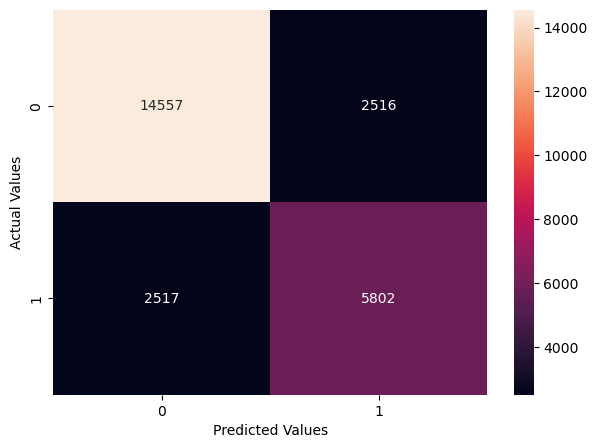

Accuracy score =  0.8
Recall score =  0.7
Precision score =  0.7
F1 score =  0.7


In [93]:
# Prediction on training data
y_pred_train_PR = np.round( lg.predict(X_train) > opt_threshold_PR)

# Confusion matrix
create_confusion_matrix(y_train, y_pred_train_PR)
dict_train_PR = print_performance_metrics(y_train, y_pred_train_PR)

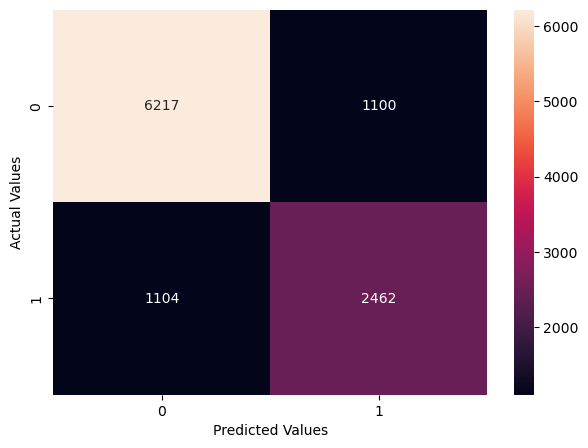

Accuracy score =  0.8
Recall score =  0.69
Precision score =  0.69
F1 score =  0.69


In [94]:
# Prediction on test data
y_pred_test_PR = np.round( lg.predict(X_test) > opt_threshold_PR)

# Confusion matrix
create_confusion_matrix(y_test, y_pred_test_PR)
dict_test_PR = print_performance_metrics(y_test, y_pred_test_PR)

### Decision Tree

#### Data preparation, feature engineering for decision tree

In [95]:
df_Inn_DT = df_InnFromCSV.drop(['Booking_ID','arrival_date'], axis = 1)
df_Inn_DT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  market_segment_type                   36275 non-null  object 
 11  repeated_guest 

In [96]:
# Perform one-hot encoding of object columns
oneHotCols = ['type_of_meal_plan','room_type_reserved','market_segment_type']
df_Inn_DT = pd.get_dummies(df_Inn_DT, columns=oneHotCols)
# Convert year and month to category
#df_Inn_DT['arrival_month'] = pd.Categorical('arrival_month')

In [97]:
df_Inn_DT['booking_status'] = df_Inn_DT['booking_status'].replace('Canceled', 1)
df_Inn_DT['booking_status'] = df_Inn_DT['booking_status'].replace('Not_Canceled', 0)
df_Inn['booking_status'].value_counts()

booking_status
0    24390
1    11885
Name: count, dtype: int64

#### Decision tree model building

In [98]:
# Create X and y for decision tree model
X_DT = df_Inn_DT.drop('booking_status', axis = 1)
y_DT = df_Inn_DT['booking_status']
X_DT = X_DT.astype(float)

In [99]:
# Create train-test split
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=.30, random_state=1)

In [100]:
dTree = DecisionTreeClassifier(criterion='gini', random_state=1)
dTree.fit(X_train_DT, y_train_DT)

DecisionTreeClassifier(random_state=1)

#### Decision tree model performance

In [101]:
print("Accuracy on train set : ",dTree.score(X_train_DT, y_train_DT))
print("Accuracy on test set : ",dTree.score(X_test_DT, y_test_DT))

Accuracy on train set :  0.9935412728418399
Accuracy on test set :  0.8692456124230451


In [102]:
y_pred_train_DT = dTree.predict(X_train_DT)
y_pred_test_DT = dTree.predict(X_test_DT)

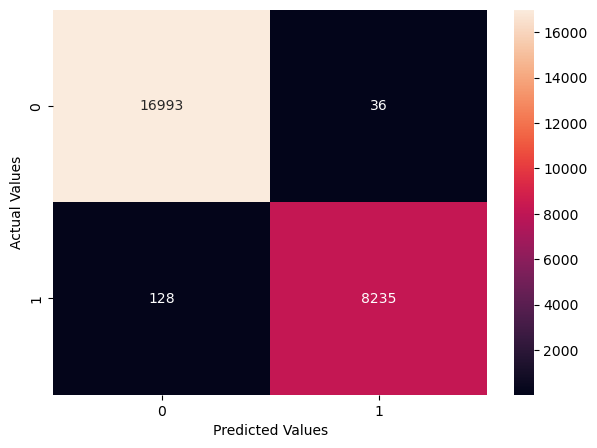

Accuracy score =  0.99
Recall score =  0.98
Precision score =  1.0
F1 score =  0.99


In [103]:
# Confusion matrix on train
create_confusion_matrix(y_train_DT, y_pred_train_DT)
dict_DT_train = print_performance_metrics(y_train_DT, y_pred_train_DT)

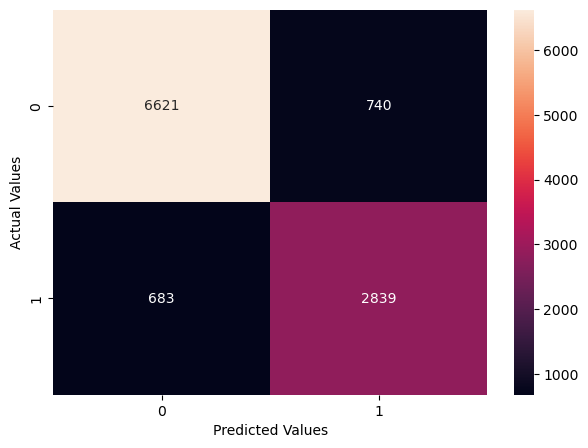

Accuracy score =  0.87
Recall score =  0.81
Precision score =  0.79
F1 score =  0.8


In [104]:
# Confusion matrix on test
create_confusion_matrix(y_test_DT, y_pred_test_DT)
dict_DT_test = print_performance_metrics(y_test_DT, y_pred_test_DT)

#### Visualizing the decision tree

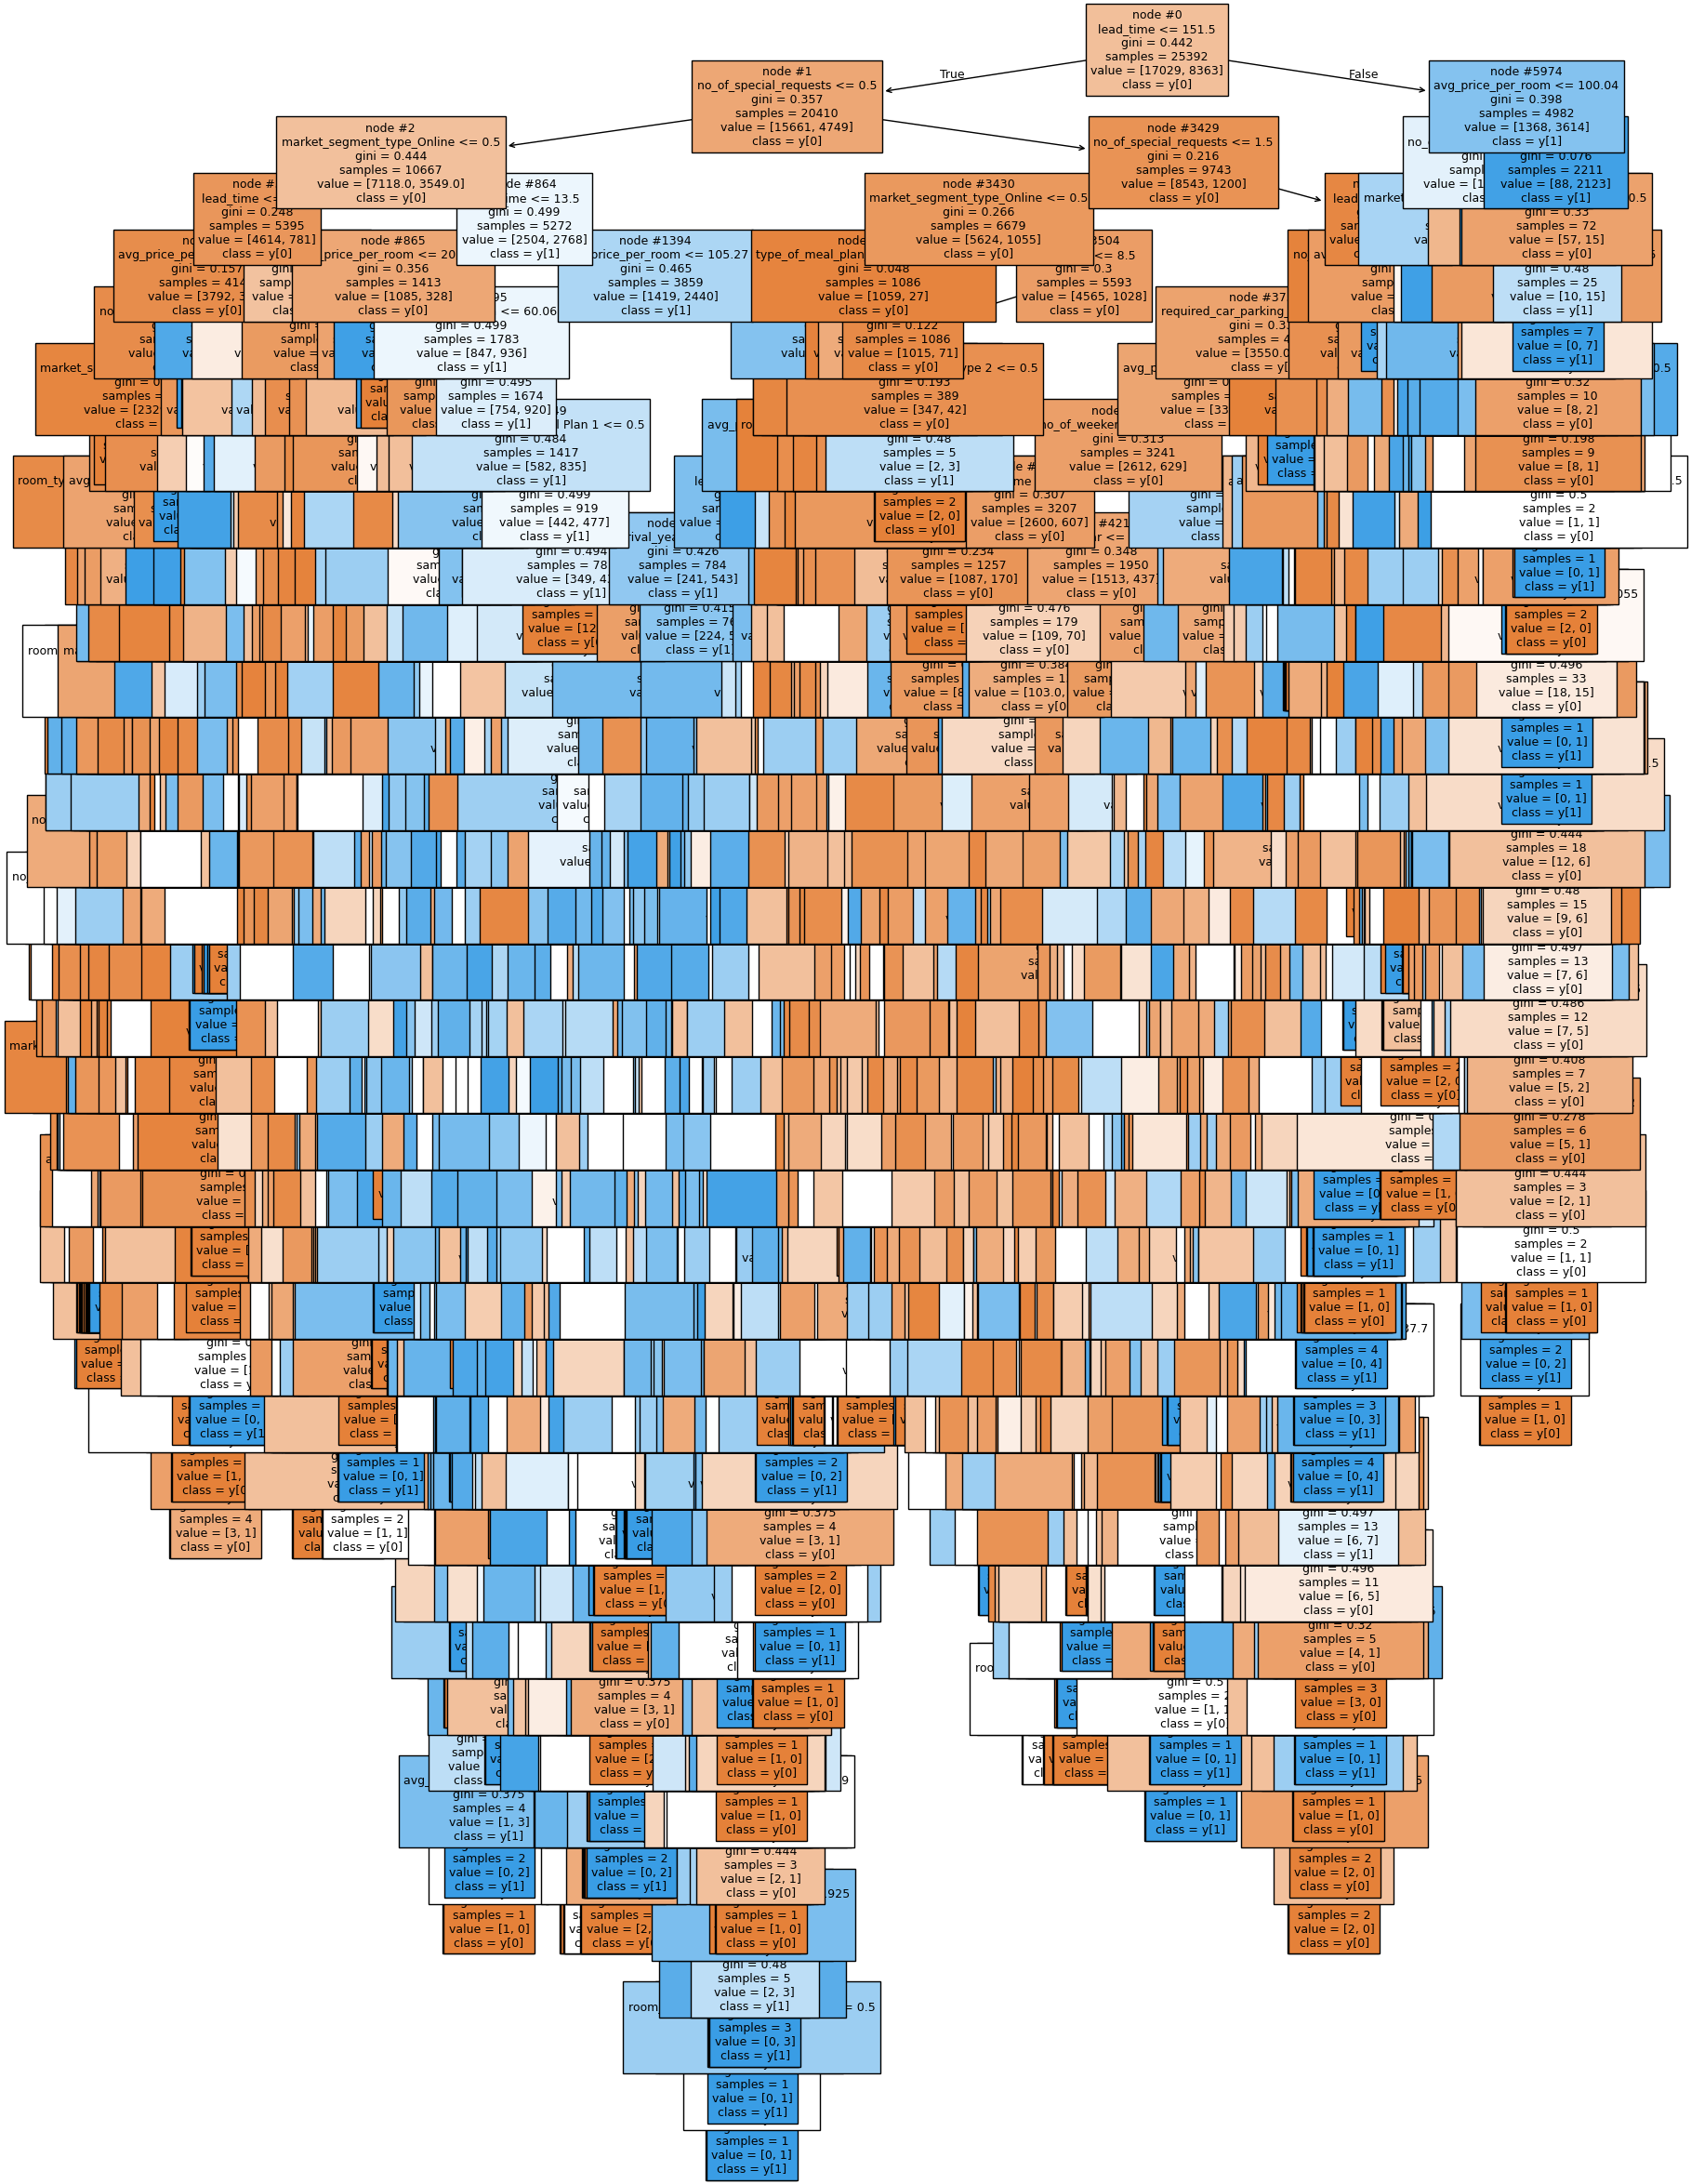

In [105]:
plt.figure(figsize=(20,30))
tree.plot_tree(dTree,feature_names=X_DT.columns,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [106]:
# Importance of features
print( pd.DataFrame( dTree.feature_importances_, columns=['Importance'], index=X_train_DT.columns ).sort_values(by = 'Importance', ascending=False) )

                                      Importance
lead_time                               0.377554
avg_price_per_room                      0.191108
market_segment_type_Online              0.094015
arrival_month                           0.080991
no_of_special_requests                  0.068257
no_of_week_nights                       0.057794
no_of_weekend_nights                    0.038489
no_of_adults                            0.029264
arrival_year                            0.013218
type_of_meal_plan_Meal Plan 1           0.007499
required_car_parking_space              0.007060
room_type_reserved_Room_Type 1          0.006347
room_type_reserved_Room_Type 4          0.006305
no_of_children                          0.005927
type_of_meal_plan_Not Selected          0.003781
market_segment_type_Offline             0.002400
type_of_meal_plan_Meal Plan 2           0.002319
room_type_reserved_Room_Type 2          0.001913
room_type_reserved_Room_Type 5          0.001452
market_segment_type_

#### Reduce overfitting by pre-pruning using GridSearch

In [107]:
DT_estimator = DecisionTreeClassifier(random_state=1)

# Set parameters
DT_parameters = { 'max_depth' : np.arange(1,8),
                'min_samples_leaf' : [1, 2, 5, 7, 10, 15, 20],
                'max_leaf_nodes' : [2, 3, 5, 10],
                'min_impurity_decrease' : [0.001, 0.01, 0.1]}

# Type of scoring to be used
DT_acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run GridSearchCV
grid_obj = GridSearchCV(DT_estimator, DT_parameters, scoring=DT_acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train_DT, y_train_DT)

# Best combination of parameters
DT_estimator = grid_obj.best_estimator_

# Fit the estimator
DT_estimator.fit(X_train_DT, y_train_DT)


DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5,
                       min_impurity_decrease=0.001, random_state=1)

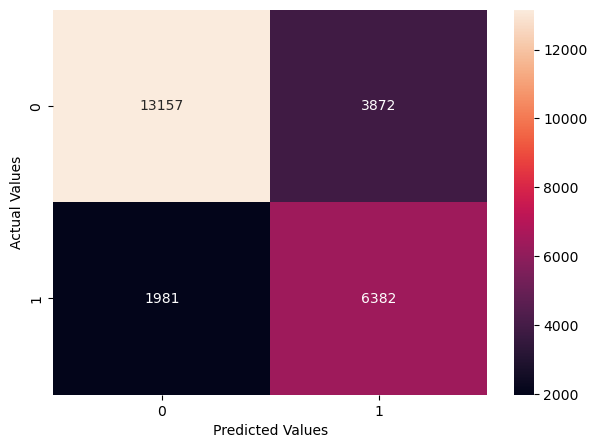

Accuracy score =  0.77
Recall score =  0.76
Precision score =  0.62
F1 score =  0.69


In [108]:
# Confusion matrix on train data
y_pred_train_DT_GS = DT_estimator.predict(X_train_DT)
create_confusion_matrix(y_train_DT, y_pred_train_DT_GS)
dict_DT_pre_train = print_performance_metrics(y_train_DT, y_pred_train_DT_GS)

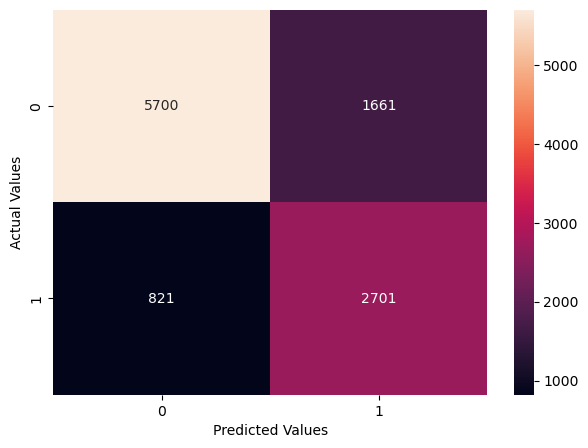

Accuracy score =  0.77
Recall score =  0.77
Precision score =  0.62
F1 score =  0.69


In [109]:
# Confusion matrix on test data
y_pred_test_DT_GS = DT_estimator.predict(X_test_DT)
create_confusion_matrix(y_test_DT, y_pred_test_DT_GS)
dict_DT_pre_test = print_performance_metrics(y_test_DT, y_pred_test_DT_GS)
 

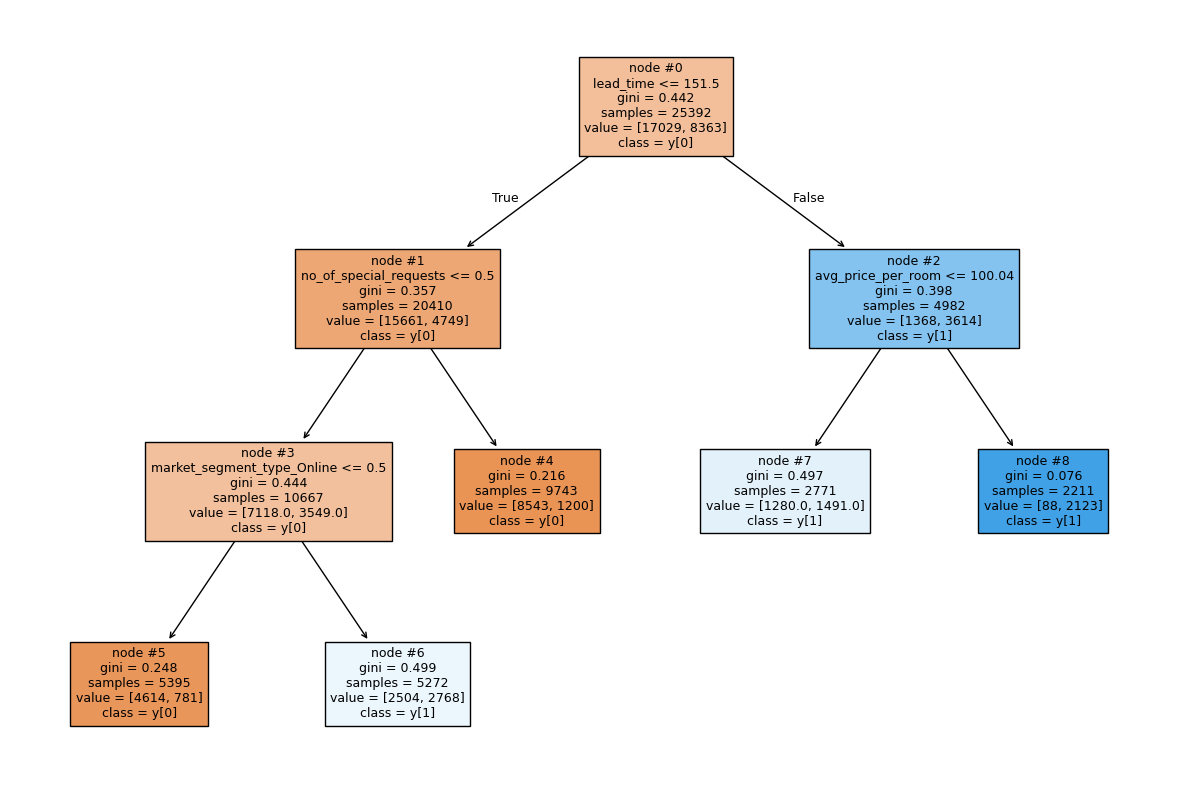

In [110]:
plt.figure(figsize=(15,10))

tree.plot_tree(DT_estimator,feature_names=X_DT.columns,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

#### Cost complexity pruning

In [111]:
clf_ccp = DecisionTreeClassifier(random_state=1)
path_ccp = clf_ccp.cost_complexity_pruning_path(X_train_DT, y_train_DT)
pd.DataFrame(path_ccp)
ccp_alphas, impurities = path_ccp.ccp_alphas[:-1], path_ccp.impurities[:-1]

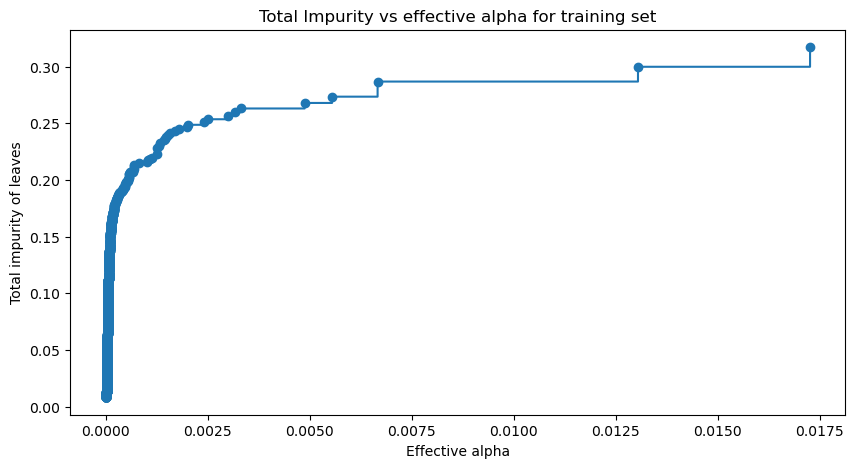

In [112]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [113]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train_DT, y_train_DT)
    clfs.append(clf)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.023990479445095594


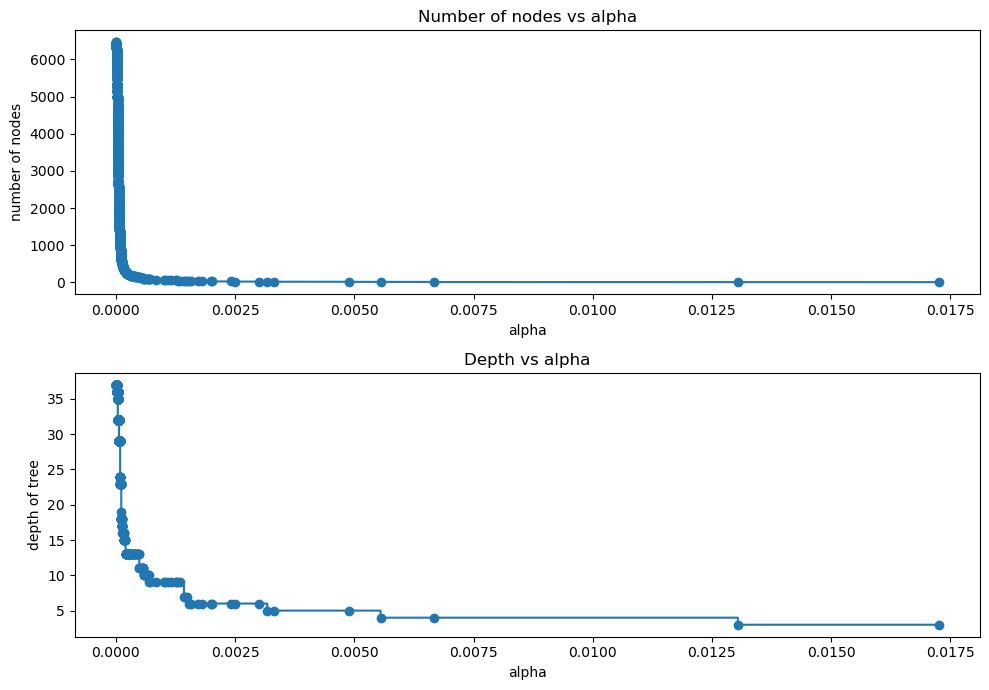

In [114]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(10,7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

In [115]:
train_scores_DT_ccp = [clf.score(X_train_DT, y_train_DT) for clf in clfs]
test_scores_DT_ccp = [clf.score(X_test_DT, y_test_DT) for clf in clfs]

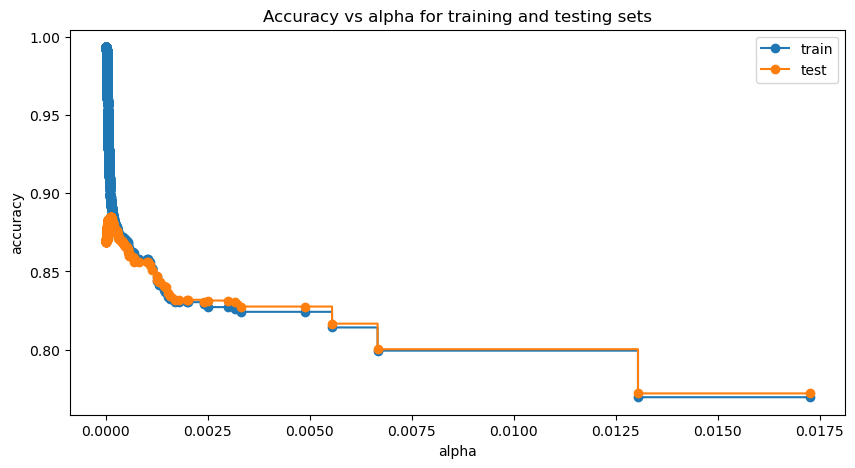

In [116]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores_DT_ccp, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_DT_ccp, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [117]:
acc_diff = np.array(train_scores_DT_ccp[:-1]) - np.array(test_scores_DT_ccp[:-1])
index_best_model_acc = np.argmin( acc_diff )
best_model_acc = clfs[index_best_model_acc]
print(best_model_acc)
print('Training accuracy of best model: ',best_model_acc.score(X_train_DT, y_train_DT))
print('Test accuracy of best model: ',best_model_acc.score(X_test_DT, y_test_DT))

DecisionTreeClassifier(ccp_alpha=0.0031728826341325643, random_state=1)
Training accuracy of best model:  0.8258112791430372
Test accuracy of best model:  0.8303776532206193


In [118]:
recall_train_ccp=[]
for clf in clfs:
    pred_train_ccp=clf.predict(X_train_DT)
    values_train_ccp=metrics.recall_score(y_train_DT,pred_train_ccp)
    recall_train_ccp.append(values_train_ccp)

In [119]:
recall_test_ccp=[]
for clf in clfs:
    pred_test_ccp=clf.predict(X_test_DT)
    values_test_ccp=metrics.recall_score(y_test_DT,pred_test_ccp)
    recall_test_ccp.append(values_test_ccp)

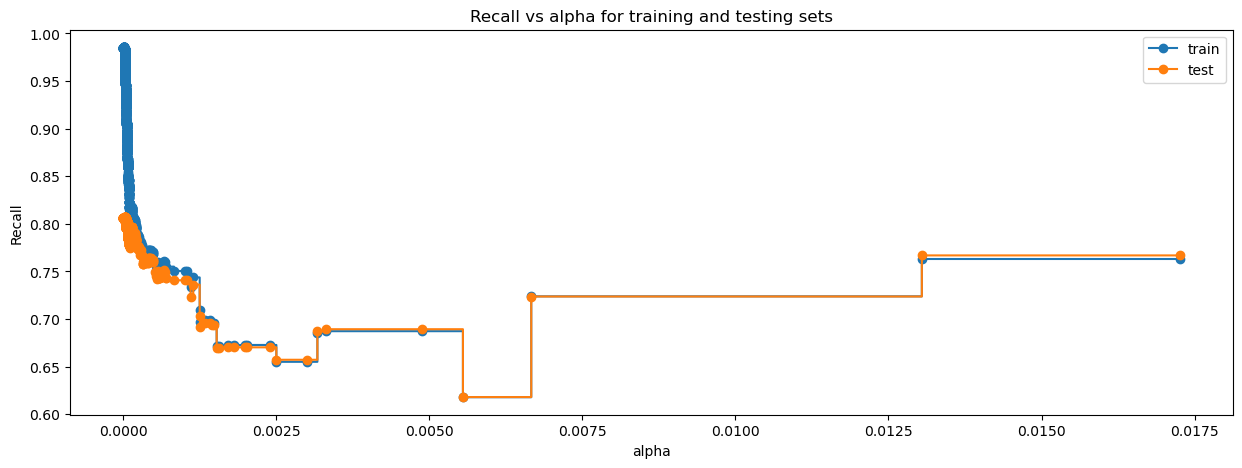

In [120]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train_ccp, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test_ccp, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [121]:
# creating the model where we get highest train and test recall
#recall_diff = np.array(recall_train_ccp[:-1]) - np.array(recall_test_ccp[:-1])
index_best_model_recall = np.argmax( recall_test_ccp )
best_model_ccp_recall = clfs[index_best_model_recall]
print(best_model_ccp_recall)

DecisionTreeClassifier(ccp_alpha=2.5061579881995774e-05, random_state=1)


In [122]:
y_pred_train_DT_ccp = best_model_ccp_recall.predict(X_train_DT)
y_pred_test_DT_ccp = best_model_ccp_recall.predict(X_test_DT)

#### Confusion matrix

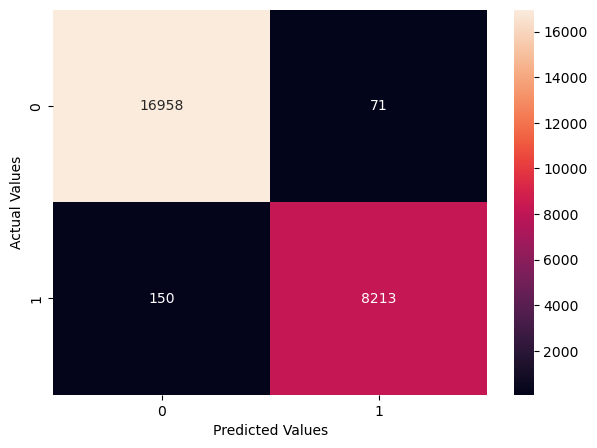

Accuracy score =  0.99
Recall score =  0.98
Precision score =  0.99
F1 score =  0.99


In [123]:
create_confusion_matrix(y_train_DT, y_pred_train_DT_ccp)
dict_train_ccp = print_performance_metrics(y_train_DT, y_pred_train_DT_ccp)

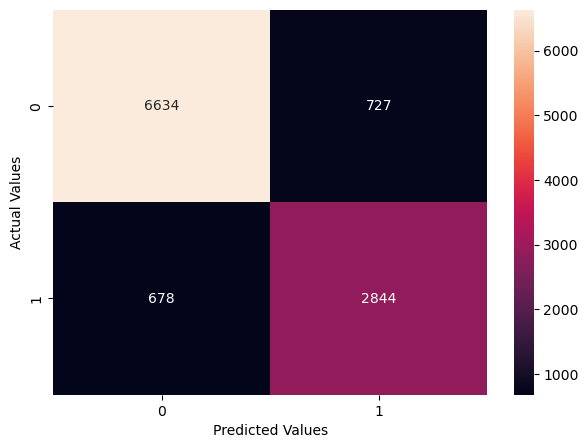

Accuracy score =  0.87
Recall score =  0.81
Precision score =  0.8
F1 score =  0.8


In [124]:
create_confusion_matrix(y_test_DT, y_pred_test_DT_ccp)
dict_test_ccp = print_performance_metrics(y_test_DT, y_pred_test_DT_ccp)

#### Visualize the decision tree

In [ ]:
plt.figure(figsize=(17,15))

tree.plot_tree(best_model_ccp_recall,feature_names=X_DT.columns,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [ ]:
# Importance of features
print( pd.DataFrame( best_model_ccp_recall.feature_importances_, columns=['Importance'], index=X_train_DT.columns ).sort_values(by = 'Importance', ascending=False) )

## Model performance comparison and final model selection

In [ ]:
df_Models = pd.DataFrame( [dict_train_def, dict_test_def, dict_train_ROC, dict_test_ROC, dict_train_PR, dict_test_PR] )

# Add row names and display df_Models
df_Models.index = ['Train_Default','Test_Default','Train_ROC','Test_ROC','Train_PR','Test_PR']
df_Models

In [ ]:
df_Models_DT = pd.DataFrame( [dict_DT_train, dict_DT_test, dict_DT_pre_train, dict_DT_pre_test, dict_train_ccp, dict_test_ccp] )

# Add row names and display df_Models
df_Models_DT.index = ['Train_Default','Test_Default','Train_Pre_Pruning','Test_Pre_Pruning','Train_Post_Pruning','Test_Post_Pruning']
df_Models_DT

In [ ]:
# Importance of features in pre-pruned decision tree
print( pd.DataFrame( DT_estimator.feature_importances_, columns=['Importance'], index=X_train_DT.columns ).sort_values(by = 'Importance', ascending=False) )